# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

# Non shared resources
filename = 'casa-lc'
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['fuel', 'machine', 'others', 'part', 'price', 'service']
aspect_mapping = {'fuel': 0, 'machine': 1, 'others': 2, 'part': 3, 'price': 4, 'service': 5 }
label_mapping = {"negative": 0, "neutral": 1, 'positive': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/casa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/casa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/casa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [7]:
data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [9]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['sentence'].values
y_train = train_data[train_labels].values
X_val = val_data['sentence'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(864,) (864, 6)
(216,) (216, 6)


# BUILD DATASET & DATALOADERS

In [10]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [11]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [12]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [13]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [14]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [15]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 25

In [16]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [17]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }


In [18]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            ['fuel', 'machine', 'others', 'part', 'price', 'service']
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [19]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [20]:
def least_confidence_sampling(aspect_model, sentiment_model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    aspect_model.to(device)
    aspect_model.eval()
    sentiment_model.to(device)
    sentiment_model.eval()

    current_train_size = len(train_indices)
    aspect_dataset = AspectDetectionDataset(
        X_pool, 
        [['neutral' for i in range(len(train_labels))] for x in range(len(X_pool))], 
        label_mapping, 
        tokenizer, 
        max_length=sequence_length
    )
    aspect_loader = DataLoader(
        aspect_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    start_time = time.time()

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        
        with torch.no_grad():
            outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            preds = torch.sigmoid(outputs.logits)

        for i in range(len(preds)):
            aspect_outputs[batch['ori_indices'][i].item()] = np.max(preds[i].cpu().numpy())
            
            for j in range(len(preds[i])):
                if int(preds[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])
    
    sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
    sentiment_loader = torch.utils.data.DataLoader(
        sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
    )

    # Pass through sentiment analysis model
    for batch in sentiment_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)

        with torch.no_grad():
            outputs = sentiment_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            preds = torch.sigmoid(outputs.logits)

        for i in range(len(preds)):
            ori_index = batch['ori_indices'][i].item()
            if ori_index in sentiment_outputs.keys():
                max_pred = np.max(preds[i].cpu().numpy())
                sentiment_outputs[ori_index] = max_pred if max_pred > sentiment_outputs[ori_index] else sentiment_outputs[ori_index]
            else:
                sentiment_outputs[ori_index] = np.max(preds[i].cpu().numpy())

    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        aspect_outputs = dict(sorted(aspect_outputs.items()))
    
        # accelerator.print(aspect_outputs)
        for key, val in sentiment_outputs.items():
            aspect_outputs[key] = 1 - ((val + aspect_outputs[key]) / 2)
    
        # accelerator.print(aspect_outputs)
        uncertainties = np.array(list(aspect_outputs.values()))
        sorted_unc = np.argsort(uncertainties)
        sorted_unc = sorted_unc[::-1]

        threshold = np.percentile(uncertainties, 90)
        items_greater_than_average = uncertainties[uncertainties >= threshold]
        num_of_candidates = len(items_greater_than_average)
        
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            least_confident_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in least_confident_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'fuel': [y_train[i][0] for i in temp],
                'machine': [y_train[i][1] for i in temp],
                'others': [y_train[i][2] for i in temp],
                'part': [y_train[i][3] for i in temp],
                'price': [y_train[i][4] for i in temp],
                'service': [y_train[i][5] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in least_confident_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(least_confident_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [21]:
def active_learning(seed, i):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed
        )
        notebook_launcher(train_model, args, num_processes=2)

        aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{i+1}-model')
        sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-{i+1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (
            aspect_model, 
            sentiment_model, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i
        )
        notebook_launcher(least_confidence_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [22]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6756, Accuracy: 0.7731, F1 Micro: 0.8711, F1 Macro: 0.8698
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5958, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5785, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.513, Accuracy: 0.7939, F1 Micro: 0.8843, F1 Macro: 0.8828
Epoch 5/10, Train Loss: 0.5006, Accuracy: 0.7924, F1 Micro: 0.8829, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4695, Accuracy: 0.7954, F1 Micro: 0.8846, F1 Macro: 0.8828
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4328, Accuracy: 0.7969, F1 Micro: 0.8857, F1 Macro: 0.8842
Epoch 8/10, Train Loss: 0.4369, Accuracy: 0.7932, F1 Micro: 0.8832, F1 Macro: 0.8812
Epoch 9/10, Train Loss: 0.415, Accuracy: 0.7917, F1 Micro: 0.8816, F1 Macro: 0.8789
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7162, Accuracy: 0.2857, F1 Micro: 0.2857, F1 Macro: 0.2222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6764, Accuracy: 0.5, F1 Micro: 0.5, F1 Macro: 0.4974
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.6621, Accuracy: 0.7143, F1 Micro: 0.7143, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.6053, Accuracy: 0.7857, F1 Micro: 0.7857, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5803, Accuracy: 0.7857, F1 Micro: 0.7857, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.5674, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4789, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4895, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Epoch 9/10, Train Loss: 0.4054, Accuracy: 0.7143, F1 Micro: 0.7143,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6141, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5112, Accuracy: 0.7917, F1 Micro: 0.8833, F1 Macro: 0.8819
Epoch 3/10, Train Loss: 0.4731, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.452, Accuracy: 0.7939, F1 Micro: 0.8844, F1 Macro: 0.883
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4247, Accuracy: 0.7999, F1 Micro: 0.8873, F1 Macro: 0.8859
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3861, Accuracy: 0.808, F1 Micro: 0.8912, F1 Macro: 0.8898
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3652, Accuracy: 0.8378, F1 Micro: 0.9061, F1 Macro: 0.905
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3331, Accuracy: 0.8534, F1 Micro: 0.9147, F1 Macro: 0.9139
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2809, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6486, Accuracy: 0.6954, F1 Micro: 0.6954, F1 Macro: 0.4102
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6037, Accuracy: 0.6954, F1 Micro: 0.6954, F1 Macro: 0.4102
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5149, Accuracy: 0.7529, F1 Micro: 0.7529, F1 Macro: 0.5833
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4421, Accuracy: 0.7644, F1 Micro: 0.7644, F1 Macro: 0.6294
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3884, Accuracy: 0.8161, F1 Micro: 0.8161, F1 Macro: 0.7602
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2866, Accuracy: 0.8851, F1 Micro: 0.8851, F1 Macro: 0.8695
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2605, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1299, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8876
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5963, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5157, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Epoch 3/10, Train Loss: 0.4929, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4647, Accuracy: 0.808, F1 Micro: 0.8913, F1 Macro: 0.8902
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4149, Accuracy: 0.8333, F1 Micro: 0.9039, F1 Macro: 0.9033
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3715, Accuracy: 0.8676, F1 Micro: 0.9223, F1 Macro: 0.9213
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3137, Accuracy: 0.9129, F1 Micro: 0.9472, F1 Macro: 0.946
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2591, Accuracy: 0.9353, F1 Micro: 0.9602, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2191, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6643, Accuracy: 0.68, F1 Micro: 0.68, F1 Macro: 0.4048
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5287, Accuracy: 0.8044, F1 Micro: 0.8044, F1 Macro: 0.7841
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3814, Accuracy: 0.8578, F1 Micro: 0.8578, F1 Macro: 0.84
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2394, Accuracy: 0.88, F1 Micro: 0.88, F1 Macro: 0.8701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2056, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8979
Epoch 6/10, Train Loss: 0.148, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.8791
Epoch 7/10, Train Loss: 0.0904, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8967
Epoch 8/10, Train Loss: 0.1646, Accuracy: 0.8533, F1 Micro: 0.8533, F1 Macro: 0.8457
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1493, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.9094
Epoch 10/10, Train Loss: 0.1201, Accuracy: 0.8933, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5885, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.492, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4754, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4292, Accuracy: 0.8021, F1 Micro: 0.8885, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3869, Accuracy: 0.8579, F1 Micro: 0.9167, F1 Macro: 0.916
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3358, Accuracy: 0.9115, F1 Micro: 0.9464, F1 Macro: 0.9454
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2766, Accuracy: 0.942, F1 Micro: 0.9641, F1 Macro: 0.9625
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2134, Accuracy: 0.9494, F1 Micro: 0.9688, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6837, Accuracy: 0.6749, F1 Micro: 0.6749, F1 Macro: 0.4148
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5532, Accuracy: 0.8807, F1 Micro: 0.8807, F1 Macro: 0.8712
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3308, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9215
Epoch 4/10, Train Loss: 0.2304, Accuracy: 0.8848, F1 Micro: 0.8848, F1 Macro: 0.8776
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1934, Accuracy: 0.9383, F1 Micro: 0.9383, F1 Macro: 0.9303
Epoch 6/10, Train Loss: 0.1048, Accuracy: 0.9259, F1 Micro: 0.9259, F1 Macro: 0.9198
Epoch 7/10, Train Loss: 0.1229, Accuracy: 0.9218, F1 Micro: 0.9218, F1 Macro: 0.9152
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1044, Accuracy: 0.9383, F1 Micro: 0.9383, F1 Macro: 0.9323
Epoch 9/10, Train Loss: 0.0754, Accuracy: 0.9342, F1 Micro: 0.9342, F1 Macro: 0.9272
Epoch 10/10, Train Loss: 0.0728, Accuracy: 0.9218, F1 Micro: 0.9218, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5718, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.4805, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4463, Accuracy: 0.811, F1 Micro: 0.8929, F1 Macro: 0.892
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3948, Accuracy: 0.8824, F1 Micro: 0.9304, F1 Macro: 0.9297
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3121, Accuracy: 0.9323, F1 Micro: 0.9583, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2439, Accuracy: 0.9412, F1 Micro: 0.9635, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2012, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.148, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1249, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.67, Accuracy: 0.7976, F1 Micro: 0.7976, F1 Macro: 0.7835
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5034, Accuracy: 0.8907, F1 Micro: 0.8907, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2859, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8961
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1739, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8953
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1423, Accuracy: 0.919, F1 Micro: 0.919, F1 Macro: 0.9093
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1382, Accuracy: 0.919, F1 Micro: 0.919, F1 Macro: 0.9122
Epoch 7/10, Train Loss: 0.1268, Accuracy: 0.915, F1 Micro: 0.915, F1 Macro: 0.908
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1088, Accuracy: 0.919, F1 Micro: 0.919, F1 Macro: 0.9122
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0868, Accuracy: 0.919, F1 Micro: 0.919, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.572, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4869, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4509, Accuracy: 0.8326, F1 Micro: 0.9035, F1 Macro: 0.9032
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3502, Accuracy: 0.9226, F1 Micro: 0.9524, F1 Macro: 0.9503
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2743, Accuracy: 0.9412, F1 Micro: 0.9635, F1 Macro: 0.9619
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.207, Accuracy: 0.9501, F1 Micro: 0.9691, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1502, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.131, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6298, Accuracy: 0.8261, F1 Micro: 0.8261, F1 Macro: 0.8015
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4541, Accuracy: 0.8972, F1 Micro: 0.8972, F1 Macro: 0.89
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2557, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9345
Epoch 4/10, Train Loss: 0.173, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9231
Epoch 5/10, Train Loss: 0.1615, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9224
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1414, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9348
Epoch 7/10, Train Loss: 0.1279, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.9067
Epoch 8/10, Train Loss: 0.0831, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9261
Epoch 9/10, Train Loss: 0.1019, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.9067
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0962, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5737, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5017, Accuracy: 0.7969, F1 Micro: 0.886, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4211, Accuracy: 0.8891, F1 Micro: 0.9342, F1 Macro: 0.9335
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.323, Accuracy: 0.9375, F1 Micro: 0.9613, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2525, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1876, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9739
Epoch 7/10, Train Loss: 0.1451, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9713
Epoch 8/10, Train Loss: 0.1128, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0955, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.621, Accuracy: 0.8157, F1 Micro: 0.8157, F1 Macro: 0.807
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3781, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.919
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2335, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9228
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.212, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9281
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1896, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9393
Epoch 6/10, Train Loss: 0.1396, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9336
Epoch 7/10, Train Loss: 0.1322, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9348
Epoch 8/10, Train Loss: 0.1159, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9234
Epoch 9/10, Train Loss: 0.1114, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9227
Epoch 10/10, Train Loss: 0.0623, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5621, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4792, Accuracy: 0.8095, F1 Micro: 0.8922, F1 Macro: 0.8911
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3983, Accuracy: 0.9048, F1 Micro: 0.9428, F1 Macro: 0.9418
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2951, Accuracy: 0.9449, F1 Micro: 0.966, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2195, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1691, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9729
Epoch 7/10, Train Loss: 0.1329, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9719
Epoch 8/10, Train Loss: 0.1046, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9712
Epoch 9/10, Train Loss: 0.0886, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.972
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6002, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.8444
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4146, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.9136
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3159, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9196
Epoch 4/10, Train Loss: 0.2208, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9154
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1851, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9347
Epoch 6/10, Train Loss: 0.1678, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9264
Epoch 7/10, Train Loss: 0.1427, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9181
Epoch 8/10, Train Loss: 0.1234, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9181
Epoch 9/10, Train Loss: 0.0971, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9099
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.1043, Accuracy: 0.9405, F1 Micro: 0.9405, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5551, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.472, Accuracy: 0.8118, F1 Micro: 0.8933, F1 Macro: 0.8922
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3669, Accuracy: 0.9263, F1 Micro: 0.9551, F1 Macro: 0.9537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2603, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.971
Epoch 5/10, Train Loss: 0.1896, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1369, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9707
Epoch 7/10, Train Loss: 0.114, Accuracy: 0.9539, F1 Micro: 0.9709, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0905, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9739
Epoch 9/10, Train Loss: 0.0762, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9724
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6103, Accuracy: 0.8672, F1 Micro: 0.8672, F1 Macro: 0.8465
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3482, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.9031
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2445, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.9031
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2468, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9262
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.202, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9352
Epoch 6/10, Train Loss: 0.1549, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9203
Epoch 7/10, Train Loss: 0.1237, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.93
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0774, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9394
Epoch 9/10, Train Loss: 0.1098, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9307
Epoch 10/10, Train Loss: 0.0906, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5535, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4728, Accuracy: 0.8177, F1 Micro: 0.8963, F1 Macro: 0.8959
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3638, Accuracy: 0.9204, F1 Micro: 0.9517, F1 Macro: 0.9504
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2758, Accuracy: 0.9464, F1 Micro: 0.967, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2017, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1502, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9738
Epoch 7/10, Train Loss: 0.1142, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9736
Epoch 8/10, Train Loss: 0.0934, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9724
Epoch 9/10, Train Loss: 0.0796, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macro: 0.9722
Higher F1 achieved, s

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5567, Accuracy: 0.8654, F1 Micro: 0.8654, F1 Macro: 0.8558
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3783, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9182
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2316, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9361
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2001, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9364
Epoch 5/10, Train Loss: 0.1512, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9309
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1382, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9354
Epoch 7/10, Train Loss: 0.1034, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.928
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0873, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9399
Epoch 9/10, Train Loss: 0.0855, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9079
Epoch 10/10, Train Loss: 0.0736, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5472, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4756, Accuracy: 0.8192, F1 Micro: 0.8973, F1 Macro: 0.8962
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3576, Accuracy: 0.9286, F1 Micro: 0.9564, F1 Macro: 0.9552
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2625, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.177, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1397, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1111, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.0911, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9751
Epoch 9/10, Train Loss: 0.0742, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6028, Accuracy: 0.8852, F1 Micro: 0.8852, F1 Macro: 0.8743
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3217, Accuracy: 0.8975, F1 Micro: 0.8975, F1 Macro: 0.8818
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2298, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9256
Epoch 4/10, Train Loss: 0.195, Accuracy: 0.9303, F1 Micro: 0.9303, F1 Macro: 0.9222
Epoch 5/10, Train Loss: 0.1829, Accuracy: 0.9262, F1 Micro: 0.9262, F1 Macro: 0.9178
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1737, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9328
Epoch 7/10, Train Loss: 0.1152, Accuracy: 0.9303, F1 Micro: 0.9303, F1 Macro: 0.9243
Epoch 8/10, Train Loss: 0.1355, Accuracy: 0.9303, F1 Micro: 0.9303, F1 Macro: 0.9239
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0985, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9452
Epoch 10/10, Train Loss: 0.0774, Accuracy: 0.9221, F1 Micro: 0.9221, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5487, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4502, Accuracy: 0.8452, F1 Micro: 0.9106, F1 Macro: 0.9101
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3242, Accuracy: 0.9323, F1 Micro: 0.9587, F1 Macro: 0.9569
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2299, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1748, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9733
Epoch 6/10, Train Loss: 0.1232, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.098, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0874, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Epoch 9/10, Train Loss: 0.071, Accuracy: 0.9561, F1 Micro: 0.9722, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5575, Accuracy: 0.8859, F1 Micro: 0.8859, F1 Macro: 0.8726
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.28, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.916
Epoch 3/10, Train Loss: 0.2571, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9012
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1884, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9365
Epoch 5/10, Train Loss: 0.1848, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9244
Epoch 6/10, Train Loss: 0.1454, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8922
Epoch 7/10, Train Loss: 0.1142, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.928
Epoch 8/10, Train Loss: 0.0971, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9223
Epoch 9/10, Train Loss: 0.0744, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9191
Epoch 10/10, Train Loss: 0.0761, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9182

Sentiment analysis accuracy: 0.943, F1 Micro: 0.943, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5416, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.437, Accuracy: 0.8757, F1 Micro: 0.9265, F1 Macro: 0.9257
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3192, Accuracy: 0.9382, F1 Micro: 0.9619, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2174, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9721
Epoch 5/10, Train Loss: 0.1703, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9719
Epoch 6/10, Train Loss: 0.1228, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.098, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9742
Epoch 8/10, Train Loss: 0.0772, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9716
Epoch 9/10, Train Loss: 0.0664, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5452, Accuracy: 0.8902, F1 Micro: 0.8902, F1 Macro: 0.8805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3053, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9269
Epoch 3/10, Train Loss: 0.2467, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9188
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2103, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9282
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2192, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9285
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1615, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9326
Epoch 7/10, Train Loss: 0.1459, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9229
Epoch 8/10, Train Loss: 0.107, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9289
Epoch 9/10, Train Loss: 0.0865, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9289
Epoch 10/10, Train Loss: 0.074, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5377, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4244, Accuracy: 0.904, F1 Micro: 0.9422, F1 Macro: 0.9412
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3069, Accuracy: 0.9442, F1 Micro: 0.9651, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2071, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.156, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1159, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Epoch 7/10, Train Loss: 0.0919, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Epoch 8/10, Train Loss: 0.0763, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5403, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8983
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2661, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9289
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1684, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.9413
Epoch 4/10, Train Loss: 0.2096, Accuracy: 0.9242, F1 Micro: 0.9242, F1 Macro: 0.9127
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.152, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.9403
Epoch 6/10, Train Loss: 0.1095, Accuracy: 0.8977, F1 Micro: 0.8977, F1 Macro: 0.8911
Epoch 7/10, Train Loss: 0.1572, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9289
Epoch 8/10, Train Loss: 0.0918, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9359
Epoch 9/10, Train Loss: 0.0803, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9206
Epoch 10/10, Train Loss: 0.0724, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.9013

Sentiment analysis accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5439, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4183, Accuracy: 0.9137, F1 Micro: 0.9475, F1 Macro: 0.9462
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2869, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1958, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1105, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0898, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.0687, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9739
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.9568, F1 Micro: 0.9727, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5031, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.8902
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2831, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9406
Epoch 3/10, Train Loss: 0.1913, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9313
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1923, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9399
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1345, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9406
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.132, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9402
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0888, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9406
Epoch 8/10, Train Loss: 0.0914, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9358
Epoch 9/10, Train Loss: 0.0628, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.9046
Epoch 10/10, Train Loss: 0.0955, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5378, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4388, Accuracy: 0.8966, F1 Micro: 0.9378, F1 Macro: 0.9367
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2903, Accuracy: 0.9479, F1 Micro: 0.9677, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1959, Accuracy: 0.9576, F1 Micro: 0.9737, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1458, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1054, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9749
Epoch 7/10, Train Loss: 0.0882, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9718
Epoch 8/10, Train Loss: 0.073, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macro: 0.9719
Epoch 9/10, Train Loss: 0.0588, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9731
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5734, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8934
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2719, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9074
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2133, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9275
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1714, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9347
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.106, Accuracy: 0.9533, F1 Micro: 0.9533, F1 Macro: 0.9479
Epoch 6/10, Train Loss: 0.0776, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.9437
Epoch 7/10, Train Loss: 0.1057, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9385
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0802, Accuracy: 0.9533, F1 Micro: 0.9533, F1 Macro: 0.9476
Epoch 9/10, Train Loss: 0.0652, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9099
Epoch 10/10, Train Loss: 0.061, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5389, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4168, Accuracy: 0.9241, F1 Micro: 0.9539, F1 Macro: 0.9527
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2776, Accuracy: 0.9464, F1 Micro: 0.9667, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1822, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1004, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0834, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0635, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Epoch 9/10, Train Loss: 0.0587, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5346, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.9028
Epoch 2/10, Train Loss: 0.2475, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.9042
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1778, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.9081
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1549, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9152
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1328, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9192
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0983, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9179
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0946, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9237
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0708, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9273
Epoch 9/10, Train Loss: 0.0639, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8958
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5307, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4195, Accuracy: 0.9196, F1 Micro: 0.9508, F1 Macro: 0.949
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.272, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1801, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1308, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9767
Epoch 6/10, Train Loss: 0.1029, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9756
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9735
Epoch 8/10, Train Loss: 0.069, Accuracy: 0.9606, F1 Micro: 0.975, F1 Macro: 0.9731
Epoch 9/10, Train Loss: 0.0569, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9758
Epoch 10/10, Train Loss: 0.0466, Accuracy: 0.9621, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5587, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.891
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2656, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9339
Epoch 3/10, Train Loss: 0.2, Accuracy: 0.9317, F1 Micro: 0.9317, F1 Macro: 0.9255
Epoch 4/10, Train Loss: 0.1367, Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.9277
Epoch 5/10, Train Loss: 0.1122, Accuracy: 0.9317, F1 Micro: 0.9317, F1 Macro: 0.9251
Epoch 6/10, Train Loss: 0.1066, Accuracy: 0.9197, F1 Micro: 0.9197, F1 Macro: 0.9126
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0894, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9336
Epoch 8/10, Train Loss: 0.0669, Accuracy: 0.9277, F1 Micro: 0.9277, F1 Macro: 0.9209
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0871, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9382
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0666, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5389, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4149, Accuracy: 0.9122, F1 Micro: 0.9469, F1 Macro: 0.9454
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.264, Accuracy: 0.9539, F1 Micro: 0.9714, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1852, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1283, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9736
Epoch 6/10, Train Loss: 0.0992, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0847, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9741
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macro: 0.9718
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5189, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.9007
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2786, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9366
Epoch 3/10, Train Loss: 0.2019, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9208
Epoch 4/10, Train Loss: 0.169, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9208
Epoch 5/10, Train Loss: 0.1551, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9179
Epoch 6/10, Train Loss: 0.1089, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.9125
Epoch 7/10, Train Loss: 0.0844, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9201
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0793, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9344
Epoch 9/10, Train Loss: 0.0585, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9281
Epoch 10/10, Train Loss: 0.06, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9261

Sentiment analysis accuracy: 0.9425, F1 Micro: 0.9425,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5374, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4156, Accuracy: 0.9234, F1 Micro: 0.9532, F1 Macro: 0.9517
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2568, Accuracy: 0.9554, F1 Micro: 0.9723, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.18, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9714
Epoch 5/10, Train Loss: 0.1292, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0967, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0807, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9801
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9769
Epoch 9/10, Train Loss: 0.0572, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9748
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5302, Accuracy: 0.8876, F1 Micro: 0.8876, F1 Macro: 0.8805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2515, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9155
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9306
Epoch 4/10, Train Loss: 0.1521, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9228
Epoch 5/10, Train Loss: 0.1353, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9228
Epoch 6/10, Train Loss: 0.1272, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9232
Epoch 7/10, Train Loss: 0.1115, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9273
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9273
Epoch 9/10, Train Loss: 0.0805, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9169
Epoch 10/10, Train Loss: 0.063, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.9016

Sentiment analysis accuracy: 0.938, F1 Micro: 0.938, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5262, Accuracy: 0.7999, F1 Micro: 0.8875, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3917, Accuracy: 0.9315, F1 Micro: 0.9579, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2484, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9722
Epoch 4/10, Train Loss: 0.1679, Accuracy: 0.9546, F1 Micro: 0.9714, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1235, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9778
Epoch 7/10, Train Loss: 0.0751, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9725
Epoch 8/10, Train Loss: 0.061, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.979
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4528, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.9116
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2439, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9244
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1776, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9379
Epoch 4/10, Train Loss: 0.1419, Accuracy: 0.9257, F1 Micro: 0.9257, F1 Macro: 0.9151
Epoch 5/10, Train Loss: 0.1448, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9257
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1232, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9372
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.9121
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.92
Epoch 9/10, Train Loss: 0.0689, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9257
Epoch 10/10, Train Loss: 0.0706, Accuracy: 0.9257, F1 Micro: 0.9257, F1 Macro: 0.9182

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5331, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4048, Accuracy: 0.9129, F1 Micro: 0.9473, F1 Macro: 0.946
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2534, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9786
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Epoch 8/10, Train Loss: 0.0635, Accuracy: 0.9628, F1 Micro: 0.9764, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9695, F1 Micro: 0.9807, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.484, Accuracy: 0.9259, F1 Micro: 0.9259, F1 Macro: 0.9167
Epoch 2/10, Train Loss: 0.2543, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9145
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1692, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.925
Epoch 4/10, Train Loss: 0.1395, Accuracy: 0.9185, F1 Micro: 0.9185, F1 Macro: 0.9098
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1347, Accuracy: 0.9481, F1 Micro: 0.9481, F1 Macro: 0.9413
Epoch 6/10, Train Loss: 0.1122, Accuracy: 0.9296, F1 Micro: 0.9296, F1 Macro: 0.9219
Epoch 7/10, Train Loss: 0.1027, Accuracy: 0.9185, F1 Micro: 0.9185, F1 Macro: 0.9098
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.929
Epoch 9/10, Train Loss: 0.064, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9258
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.085, Accuracy: 0.9519, F1 Micro: 0.9519, F1 Macro: 0.945

Sentiment analysis accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5228, Accuracy: 0.808, F1 Micro: 0.8914, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3877, Accuracy: 0.9286, F1 Micro: 0.9557, F1 Macro: 0.9536
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2398, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1727, Accuracy: 0.9621, F1 Micro: 0.9764, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.121, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0944, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9787
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9784
Epoch 8/10, Train Loss: 0.0643, Accuracy: 0.9628, F1 Micro: 0.9764, F1 Macro: 0.9744
Epoch 9/10, Train Loss: 0.0538, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4835, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.9058
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2544, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9282
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.151, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.9322
Epoch 4/10, Train Loss: 0.128, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.914
Epoch 5/10, Train Loss: 0.1295, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.9258
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1196, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9373
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9373
Epoch 8/10, Train Loss: 0.0734, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9264
Epoch 9/10, Train Loss: 0.0774, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.9197
Epoch 10/10, Train Loss: 0.0637, Accuracy: 0.9326, F1 Micro: 0.9326, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5175, Accuracy: 0.8013, F1 Micro: 0.8882, F1 Macro: 0.8869
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3823, Accuracy: 0.9219, F1 Micro: 0.9516, F1 Macro: 0.9489
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2489, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1275, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.965, F1 Micro: 0.9778, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9782
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4675, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.921
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2165, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9289
Epoch 3/10, Train Loss: 0.1544, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.91
Epoch 4/10, Train Loss: 0.1198, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9233
Epoch 5/10, Train Loss: 0.1005, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9201
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0882, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9285
Epoch 7/10, Train Loss: 0.0764, Accuracy: 0.9242, F1 Micro: 0.9242, F1 Macro: 0.9174
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9282
Epoch 9/10, Train Loss: 0.0568, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9253
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0353, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro

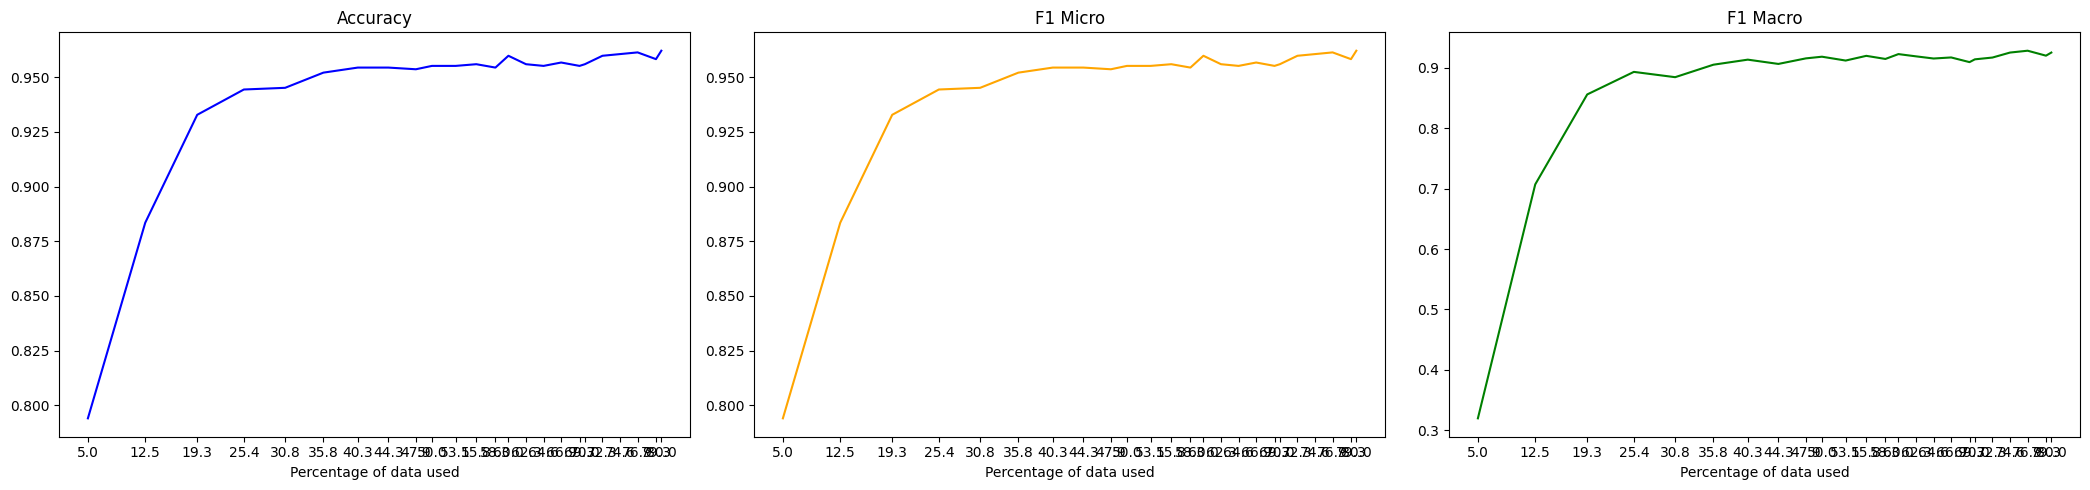

In [23]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.647, Accuracy: 0.7054, F1 Micro: 0.8127, F1 Macro: 0.7262
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5731, Accuracy: 0.7374, F1 Micro: 0.8408, F1 Macro: 0.7949
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5493, Accuracy: 0.7917, F1 Micro: 0.8824, F1 Macro: 0.8802
Epoch 4/10, Train Loss: 0.5049, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Epoch 5/10, Train Loss: 0.4781, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 6/10, Train Loss: 0.4364, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4061, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Epoch 8/10, Train Loss: 0.4421, Accuracy: 0.7902, F1 Micro: 0.8825, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.4208, Accuracy: 0.7939, F1 Micro: 0.8842, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6351, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5577, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5004, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4905, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4593, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4341, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4188, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2323, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.603, Accuracy: 0.7403, F1 Micro: 0.8433, F1 Macro: 0.8018
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4979, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4668, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4383, Accuracy: 0.8006, F1 Micro: 0.8876, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3929, Accuracy: 0.8051, F1 Micro: 0.8892, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3576, Accuracy: 0.8281, F1 Micro: 0.9007, F1 Macro: 0.899
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3356, Accuracy: 0.869, F1 Micro: 0.9222, F1 Macro: 0.9208
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2741, Accuracy: 0.8869, F1 Micro: 0.9312, F1 Macro: 0.929
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5659, Accuracy: 0.715, F1 Micro: 0.715, F1 Macro: 0.4328
Epoch 2/10, Train Loss: 0.5337, Accuracy: 0.7101, F1 Micro: 0.7101, F1 Macro: 0.4153
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.468, Accuracy: 0.744, F1 Micro: 0.744, F1 Macro: 0.6432
Epoch 4/10, Train Loss: 0.3475, Accuracy: 0.7391, F1 Micro: 0.7391, F1 Macro: 0.6832
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.235, Accuracy: 0.7681, F1 Micro: 0.7681, F1 Macro: 0.7476
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1642, Accuracy: 0.8213, F1 Micro: 0.8213, F1 Macro: 0.7967
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1433, Accuracy: 0.8261, F1 Micro: 0.8261, F1 Macro: 0.8014
Epoch 8/10, Train Loss: 0.1269, Accuracy: 0.8019, F1 Micro: 0.8019, F1 Macro: 0.7824
Epoch 9/10, Train Loss: 0.1273, Accuracy: 0.8213, F1 Micro: 0.8213, F1 Macro: 0.7934
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0852, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5904, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4903, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4862, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4577, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4023, Accuracy: 0.8326, F1 Micro: 0.9038, F1 Macro: 0.9024
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3388, Accuracy: 0.8891, F1 Micro: 0.9332, F1 Macro: 0.9313
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2835, Accuracy: 0.9182, F1 Micro: 0.9497, F1 Macro: 0.9474
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2241, Accuracy: 0.9263, F1 Micro: 0.9544, F1 Macro: 0.9522
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6228, Accuracy: 0.671, F1 Micro: 0.671, F1 Macro: 0.4139
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5747, Accuracy: 0.7186, F1 Micro: 0.7186, F1 Macro: 0.5693
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4497, Accuracy: 0.8485, F1 Micro: 0.8485, F1 Macro: 0.8312
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2688, Accuracy: 0.8961, F1 Micro: 0.8961, F1 Macro: 0.8846
Epoch 5/10, Train Loss: 0.1804, Accuracy: 0.8874, F1 Micro: 0.8874, F1 Macro: 0.8801
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1473, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8952
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1088, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8999
Epoch 8/10, Train Loss: 0.0767, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8927
Epoch 9/10, Train Loss: 0.0821, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.896
Epoch 10/10, Train Loss: 0.0965, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5698, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5056, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 3/10, Train Loss: 0.4603, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4356, Accuracy: 0.8304, F1 Micro: 0.9026, F1 Macro: 0.9012
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3507, Accuracy: 0.9115, F1 Micro: 0.9458, F1 Macro: 0.9437
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2871, Accuracy: 0.9204, F1 Micro: 0.9505, F1 Macro: 0.9485
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2449, Accuracy: 0.939, F1 Micro: 0.962, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1823, Accuracy: 0.9412, F1 Micro: 0.9632, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1484, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6009, Accuracy: 0.6733, F1 Micro: 0.6733, F1 Macro: 0.4024
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4601, Accuracy: 0.8406, F1 Micro: 0.8406, F1 Macro: 0.8211
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3081, Accuracy: 0.8924, F1 Micro: 0.8924, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2038, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8915
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.9044, F1 Micro: 0.9044, F1 Macro: 0.8926
Epoch 6/10, Train Loss: 0.0741, Accuracy: 0.8964, F1 Micro: 0.8964, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1533, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.898
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.084, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9079
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8997
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5551, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4763, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4467, Accuracy: 0.811, F1 Micro: 0.893, F1 Macro: 0.8916
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3654, Accuracy: 0.9092, F1 Micro: 0.9445, F1 Macro: 0.9422
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3003, Accuracy: 0.9323, F1 Micro: 0.958, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2234, Accuracy: 0.9449, F1 Micro: 0.9655, F1 Macro: 0.9637
Epoch 7/10, Train Loss: 0.1814, Accuracy: 0.9412, F1 Micro: 0.963, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1431, Accuracy: 0.9524, F1 Micro: 0.9701, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1117, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6131, Accuracy: 0.7052, F1 Micro: 0.7052, F1 Macro: 0.5448
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4505, Accuracy: 0.8924, F1 Micro: 0.8924, F1 Macro: 0.8789
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3009, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9237
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1838, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9237
Epoch 5/10, Train Loss: 0.137, Accuracy: 0.9243, F1 Micro: 0.9243, F1 Macro: 0.9171
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1096, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9269
Epoch 7/10, Train Loss: 0.1179, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9109
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1002, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9269
Epoch 9/10, Train Loss: 0.0703, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9208
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5488, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4817, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4074, Accuracy: 0.8906, F1 Micro: 0.9345, F1 Macro: 0.9328
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3113, Accuracy: 0.9323, F1 Micro: 0.9583, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2411, Accuracy: 0.9472, F1 Micro: 0.967, F1 Macro: 0.9654
Epoch 6/10, Train Loss: 0.1836, Accuracy: 0.9449, F1 Micro: 0.9653, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1432, Accuracy: 0.9494, F1 Micro: 0.9682, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1193, Accuracy: 0.9516, F1 Micro: 0.9694, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0975, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6172, Accuracy: 0.7917, F1 Micro: 0.7917, F1 Macro: 0.7607
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4709, Accuracy: 0.8939, F1 Micro: 0.8939, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2571, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9073
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2277, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9193
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1973, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9269
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1278, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9322
Epoch 7/10, Train Loss: 0.1031, Accuracy: 0.9205, F1 Micro: 0.9205, F1 Macro: 0.9139
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9249
Epoch 9/10, Train Loss: 0.0623, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9178
Epoch 10/10, Train Loss: 0.0735, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5551, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4773, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4015, Accuracy: 0.8943, F1 Micro: 0.9361, F1 Macro: 0.9349
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3095, Accuracy: 0.933, F1 Micro: 0.9584, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2346, Accuracy: 0.9464, F1 Micro: 0.9667, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1799, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9736
Epoch 7/10, Train Loss: 0.1399, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9717
Epoch 8/10, Train Loss: 0.1139, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9709
Epoch 9/10, Train Loss: 0.091, Accuracy: 0.9524, F1 Micro: 0.97, F1 Macro: 0.9676
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6573, Accuracy: 0.7805, F1 Micro: 0.7805, F1 Macro: 0.7745
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4707, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.9041
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2879, Accuracy: 0.9512, F1 Micro: 0.9512, F1 Macro: 0.9458
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.254, Accuracy: 0.9553, F1 Micro: 0.9553, F1 Macro: 0.9512
Epoch 5/10, Train Loss: 0.1947, Accuracy: 0.9512, F1 Micro: 0.9512, F1 Macro: 0.9466
Epoch 6/10, Train Loss: 0.1323, Accuracy: 0.939, F1 Micro: 0.939, F1 Macro: 0.9341
Epoch 7/10, Train Loss: 0.1167, Accuracy: 0.9431, F1 Micro: 0.9431, F1 Macro: 0.9364
Epoch 8/10, Train Loss: 0.0922, Accuracy: 0.9512, F1 Micro: 0.9512, F1 Macro: 0.9469
Epoch 9/10, Train Loss: 0.0853, Accuracy: 0.939, F1 Micro: 0.939, F1 Macro: 0.9341
Epoch 10/10, Train Loss: 0.069, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9424

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5448, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4565, Accuracy: 0.8006, F1 Micro: 0.8879, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.385, Accuracy: 0.9048, F1 Micro: 0.942, F1 Macro: 0.9406
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2813, Accuracy: 0.9382, F1 Micro: 0.962, F1 Macro: 0.9607
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2031, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1748, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1277, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9744
Epoch 8/10, Train Loss: 0.0996, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9709
Epoch 9/10, Train Loss: 0.0925, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6537, Accuracy: 0.7952, F1 Micro: 0.7952, F1 Macro: 0.7834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4146, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.9007
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2276, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.943
Epoch 4/10, Train Loss: 0.1837, Accuracy: 0.9317, F1 Micro: 0.9317, F1 Macro: 0.9251
Epoch 5/10, Train Loss: 0.1584, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9388
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1202, Accuracy: 0.9518, F1 Micro: 0.9518, F1 Macro: 0.9458
Epoch 7/10, Train Loss: 0.0832, Accuracy: 0.9197, F1 Micro: 0.9197, F1 Macro: 0.9134
Epoch 8/10, Train Loss: 0.0885, Accuracy: 0.9277, F1 Micro: 0.9277, F1 Macro: 0.9221
Epoch 9/10, Train Loss: 0.0899, Accuracy: 0.9277, F1 Micro: 0.9277, F1 Macro: 0.9217
Epoch 10/10, Train Loss: 0.0528, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.9411

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.534, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4652, Accuracy: 0.8185, F1 Micro: 0.8968, F1 Macro: 0.8954
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3484, Accuracy: 0.9211, F1 Micro: 0.9513, F1 Macro: 0.9493
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2484, Accuracy: 0.9464, F1 Micro: 0.9666, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1883, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1484, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9745
Epoch 7/10, Train Loss: 0.1129, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9726
Epoch 8/10, Train Loss: 0.0913, Accuracy: 0.9576, F1 Micro: 0.9732, F1 Macro: 0.9711
Epoch 9/10, Train Loss: 0.0771, Accuracy: 0.9576, F1 Micro: 0.9732, F1 Macro: 0.9706
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6274, Accuracy: 0.8156, F1 Micro: 0.8156, F1 Macro: 0.8071
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3745, Accuracy: 0.9303, F1 Micro: 0.9303, F1 Macro: 0.9222
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2423, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9455
Epoch 4/10, Train Loss: 0.1561, Accuracy: 0.9426, F1 Micro: 0.9426, F1 Macro: 0.9381
Epoch 5/10, Train Loss: 0.1714, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9328
Epoch 6/10, Train Loss: 0.1256, Accuracy: 0.9467, F1 Micro: 0.9467, F1 Macro: 0.9412
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1048, Accuracy: 0.9549, F1 Micro: 0.9549, F1 Macro: 0.9507
Epoch 8/10, Train Loss: 0.0964, Accuracy: 0.9467, F1 Micro: 0.9467, F1 Macro: 0.9421
Epoch 9/10, Train Loss: 0.0987, Accuracy: 0.9426, F1 Micro: 0.9426, F1 Macro: 0.9378
Epoch 10/10, Train Loss: 0.0616, Accuracy: 0.9426, F1 Micro: 0.9426, F1 Macro: 0.9372

Sentiment analys

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5323, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4484, Accuracy: 0.849, F1 Micro: 0.9122, F1 Macro: 0.9113
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3363, Accuracy: 0.9241, F1 Micro: 0.9533, F1 Macro: 0.9514
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.245, Accuracy: 0.9501, F1 Micro: 0.9687, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1883, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1366, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9748
Epoch 7/10, Train Loss: 0.1138, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9725
Epoch 8/10, Train Loss: 0.0889, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0724, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6496, Accuracy: 0.7248, F1 Micro: 0.7248, F1 Macro: 0.6252
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4094, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9115
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2219, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9324
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2157, Accuracy: 0.9535, F1 Micro: 0.9535, F1 Macro: 0.9483
Epoch 5/10, Train Loss: 0.1273, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8961
Epoch 6/10, Train Loss: 0.1529, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.8982
Epoch 7/10, Train Loss: 0.1119, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9351
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.9396
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0858, Accuracy: 0.9535, F1 Micro: 0.9535, F1 Macro: 0.948
Epoch 10/10, Train Loss: 0.0628, Accuracy: 0.9419, F1 Micro: 0.9419, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5483, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4522, Accuracy: 0.8467, F1 Micro: 0.9114, F1 Macro: 0.9107
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3282, Accuracy: 0.9345, F1 Micro: 0.9596, F1 Macro: 0.9581
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2278, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1736, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1321, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9735
Epoch 7/10, Train Loss: 0.1025, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9727
Epoch 8/10, Train Loss: 0.08, Accuracy: 0.9576, F1 Micro: 0.9732, F1 Macro: 0.9709
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.9568, F1 Micro: 0.9727, F1 Macro: 0.9701
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6043, Accuracy: 0.7744, F1 Micro: 0.7744, F1 Macro: 0.7702
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.357, Accuracy: 0.9248, F1 Micro: 0.9248, F1 Macro: 0.9151
Epoch 3/10, Train Loss: 0.2236, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.9071
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1575, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9296
Epoch 5/10, Train Loss: 0.1889, Accuracy: 0.8872, F1 Micro: 0.8872, F1 Macro: 0.8798
Epoch 6/10, Train Loss: 0.1672, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9204
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1088, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9292
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0827, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9292
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9354
Epoch 10/10, Train Loss: 0.0638, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.54, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4452, Accuracy: 0.8683, F1 Micro: 0.9227, F1 Macro: 0.9217
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.311, Accuracy: 0.9338, F1 Micro: 0.9587, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2193, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9697
Epoch 5/10, Train Loss: 0.1562, Accuracy: 0.9539, F1 Micro: 0.9709, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1262, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9746
Epoch 7/10, Train Loss: 0.0977, Accuracy: 0.9576, F1 Micro: 0.9732, F1 Macro: 0.9708
Epoch 8/10, Train Loss: 0.0771, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9714
Epoch 9/10, Train Loss: 0.0654, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5989, Accuracy: 0.8662, F1 Micro: 0.8662, F1 Macro: 0.8549
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.336, Accuracy: 0.9182, F1 Micro: 0.9182, F1 Macro: 0.9091
Epoch 3/10, Train Loss: 0.2478, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.9066
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1726, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9296
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1581, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9296
Epoch 6/10, Train Loss: 0.1238, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9249
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.094, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9262
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9517, F1 Micro: 0.9517, F1 Macro: 0.9453
Epoch 9/10, Train Loss: 0.0807, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9332
Epoch 10/10, Train Loss: 0.0716, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5423, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4289, Accuracy: 0.8914, F1 Micro: 0.9351, F1 Macro: 0.9338
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3148, Accuracy: 0.9375, F1 Micro: 0.9615, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2162, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1602, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9754
Epoch 6/10, Train Loss: 0.1202, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0972, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9774
Epoch 8/10, Train Loss: 0.0705, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9744
Epoch 9/10, Train Loss: 0.0673, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9756
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.57, Accuracy: 0.8726, F1 Micro: 0.8726, F1 Macro: 0.856
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2644, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8968
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1998, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9176
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.173, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9193
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9271
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1292, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9353
Epoch 7/10, Train Loss: 0.1119, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9315
Epoch 8/10, Train Loss: 0.0885, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9262
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9238
Epoch 10/10, Train Loss: 0.0668, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5274, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.413, Accuracy: 0.904, F1 Micro: 0.9417, F1 Macro: 0.9399
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2851, Accuracy: 0.9487, F1 Micro: 0.9682, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2004, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1451, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1118, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9771
Epoch 7/10, Train Loss: 0.0905, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9738
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9742
Epoch 9/10, Train Loss: 0.0597, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9744
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5436, Accuracy: 0.872, F1 Micro: 0.872, F1 Macro: 0.8611
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2769, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9219
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2085, Accuracy: 0.94, F1 Micro: 0.94, F1 Macro: 0.9347
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1224, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9462
Epoch 5/10, Train Loss: 0.133, Accuracy: 0.936, F1 Micro: 0.936, F1 Macro: 0.9302
Epoch 6/10, Train Loss: 0.0866, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9383
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0799, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9468
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.94, F1 Micro: 0.94, F1 Macro: 0.933
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0697, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9474
Epoch 10/10, Train Loss: 0.0509, Accuracy: 0.936, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.54, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.401, Accuracy: 0.9144, F1 Micro: 0.9478, F1 Macro: 0.9466
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.271, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1919, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9759
Epoch 6/10, Train Loss: 0.1026, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0867, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0559, Accuracy: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5576, Accuracy: 0.8745, F1 Micro: 0.8745, F1 Macro: 0.8588
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2998, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9344
Epoch 3/10, Train Loss: 0.2208, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9306
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1479, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9351
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1327, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.9431
Epoch 6/10, Train Loss: 0.139, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.934
Epoch 7/10, Train Loss: 0.0909, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9306
Epoch 8/10, Train Loss: 0.0813, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9344
Epoch 9/10, Train Loss: 0.0751, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9268
Epoch 10/10, Train Loss: 0.0567, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9306

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5317, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4087, Accuracy: 0.8973, F1 Micro: 0.936, F1 Macro: 0.9333
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.268, Accuracy: 0.9472, F1 Micro: 0.9674, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1925, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1431, Accuracy: 0.965, F1 Micro: 0.9782, F1 Macro: 0.9773
Epoch 6/10, Train Loss: 0.1013, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0877, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9773
Epoch 8/10, Train Loss: 0.0701, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0588, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5704, Accuracy: 0.8919, F1 Micro: 0.8919, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3063, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.918
Epoch 3/10, Train Loss: 0.201, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8929
Epoch 4/10, Train Loss: 0.1853, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9117
Epoch 5/10, Train Loss: 0.1462, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9086
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.151, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9312
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1044, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9356
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9161
Epoch 9/10, Train Loss: 0.0763, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9117
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0391, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5211, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3891, Accuracy: 0.9129, F1 Micro: 0.9463, F1 Macro: 0.9438
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2672, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1805, Accuracy: 0.9531, F1 Micro: 0.9706, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1321, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1063, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.9802
Epoch 8/10, Train Loss: 0.0647, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9721
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5519, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.899
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2586, Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.9426
Epoch 3/10, Train Loss: 0.1821, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.938
Epoch 4/10, Train Loss: 0.132, Accuracy: 0.9274, F1 Micro: 0.9274, F1 Macro: 0.9219
Epoch 5/10, Train Loss: 0.1132, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.9387
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0793, Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.9426
Epoch 7/10, Train Loss: 0.109, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.9387
Epoch 8/10, Train Loss: 0.0711, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9174
Epoch 9/10, Train Loss: 0.0792, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9121
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0591, Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.9423

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5246, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3824, Accuracy: 0.9249, F1 Micro: 0.9533, F1 Macro: 0.9513
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2594, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1732, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1277, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1044, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.0556, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5178, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8976
Epoch 2/10, Train Loss: 0.252, Accuracy: 0.8876, F1 Micro: 0.8876, F1 Macro: 0.8801
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1727, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.9214
Epoch 4/10, Train Loss: 0.1561, Accuracy: 0.9251, F1 Micro: 0.9251, F1 Macro: 0.9175
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1305, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.925
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0876, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.9246
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.091, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.9254
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0876, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.9218
Epoch 9/10, Train Loss: 0.0806, Accuracy: 0.8989, F1 Micro: 0.8989, F1 Macro: 0.8909
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5236, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3885, Accuracy: 0.9219, F1 Micro: 0.9514, F1 Macro: 0.9488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2456, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1747, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1297, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.099, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9763
Epoch 8/10, Train Loss: 0.0638, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0556, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.551, Accuracy: 0.8918, F1 Micro: 0.8918, F1 Macro: 0.8755
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2353, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9179
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1698, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9364
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1465, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.9401
Epoch 5/10, Train Loss: 0.1534, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9256
Epoch 6/10, Train Loss: 0.1217, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.9107
Epoch 7/10, Train Loss: 0.0978, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9327
Epoch 8/10, Train Loss: 0.0689, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9181
Epoch 9/10, Train Loss: 0.064, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9181
Epoch 10/10, Train Loss: 0.0647, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9287

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5314, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3839, Accuracy: 0.9085, F1 Micro: 0.9423, F1 Macro: 0.9388
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.247, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1752, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1263, Accuracy: 0.9606, F1 Micro: 0.975, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0976, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9758
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.9606, F1 Micro: 0.975, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9771
Epoch 9/10, Train Loss: 0.056, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5156, Accuracy: 0.8783, F1 Micro: 0.8783, F1 Macro: 0.8508
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2796, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9182
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1759, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9406
Epoch 4/10, Train Loss: 0.1173, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9295
Epoch 5/10, Train Loss: 0.128, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9164
Epoch 6/10, Train Loss: 0.1028, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.924
Epoch 7/10, Train Loss: 0.0939, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9164
Epoch 8/10, Train Loss: 0.0963, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9354
Epoch 9/10, Train Loss: 0.0646, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9368
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0707, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9402

Sentiment analysis accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5156, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3729, Accuracy: 0.9278, F1 Micro: 0.9551, F1 Macro: 0.9522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2399, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.172, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.122, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9769
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9785
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9725,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5268, Accuracy: 0.886, F1 Micro: 0.886, F1 Macro: 0.8702
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2644, Accuracy: 0.9301, F1 Micro: 0.9301, F1 Macro: 0.9226
Epoch 3/10, Train Loss: 0.1515, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9153
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1492, Accuracy: 0.9301, F1 Micro: 0.9301, F1 Macro: 0.9222
Epoch 5/10, Train Loss: 0.122, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9153
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1288, Accuracy: 0.9338, F1 Micro: 0.9338, F1 Macro: 0.9265
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0973, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9343
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0854, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9348
Epoch 9/10, Train Loss: 0.0807, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.9039
Epoch 10/10, Train Loss: 0.0521, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5244, Accuracy: 0.7976, F1 Micro: 0.8864, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3671, Accuracy: 0.9293, F1 Micro: 0.9562, F1 Macro: 0.9538
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2311, Accuracy: 0.9576, F1 Micro: 0.9737, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1601, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1301, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0943, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.9789
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Epoch 8/10, Train Loss: 0.0635, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9785
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9778
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4876, Accuracy: 0.881, F1 Micro: 0.881, F1 Macro: 0.8733
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2538, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.9144
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2018, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9437
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.142, Accuracy: 0.9524, F1 Micro: 0.9524, F1 Macro: 0.947
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1011, Accuracy: 0.9524, F1 Micro: 0.9524, F1 Macro: 0.9476
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0864, Accuracy: 0.9563, F1 Micro: 0.9563, F1 Macro: 0.9521
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0902, Accuracy: 0.9603, F1 Micro: 0.9603, F1 Macro: 0.9563
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9437
Epoch 9/10, Train Loss: 0.079, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9353
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5251, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3603, Accuracy: 0.9263, F1 Micro: 0.9538, F1 Macro: 0.9512
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2333, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1187, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9779
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0909, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9783
Epoch 7/10, Train Loss: 0.0775, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9702, F1 Micro: 0.9812, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4818, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9065
Epoch 2/10, Train Loss: 0.2294, Accuracy: 0.8769, F1 Micro: 0.8769, F1 Macro: 0.8705
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1947, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.9123
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1408, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9361
Epoch 5/10, Train Loss: 0.1571, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9204
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9354
Epoch 7/10, Train Loss: 0.1079, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9243
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.9446
Epoch 9/10, Train Loss: 0.0762, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9324
Epoch 10/10, Train Loss: 0.0725, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5122, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3625, Accuracy: 0.9308, F1 Micro: 0.9572, F1 Macro: 0.9551
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2296, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1639, Accuracy: 0.965, F1 Micro: 0.9782, F1 Macro: 0.9771
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9764
Epoch 6/10, Train Loss: 0.091, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9763
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.9628, F1 Micro: 0.9764, F1 Macro: 0.9741
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9783
Epoch 10/10, Train Loss: 0.0432, Accuracy: 0.9658, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4889, Accuracy: 0.8955, F1 Micro: 0.8955, F1 Macro: 0.8869
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2283, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9093
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1465, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9295
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1204, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9371
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9251
Epoch 6/10, Train Loss: 0.0766, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9133
Epoch 7/10, Train Loss: 0.0869, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9162
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9315
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0616, Accuracy: 0.9515, F1 Micro: 0.9515, F1 Macro: 0.9455
Epoch 10/10, Train Loss: 0.054, Accuracy: 0.9403, F1 Micro: 0.9403, F1 M

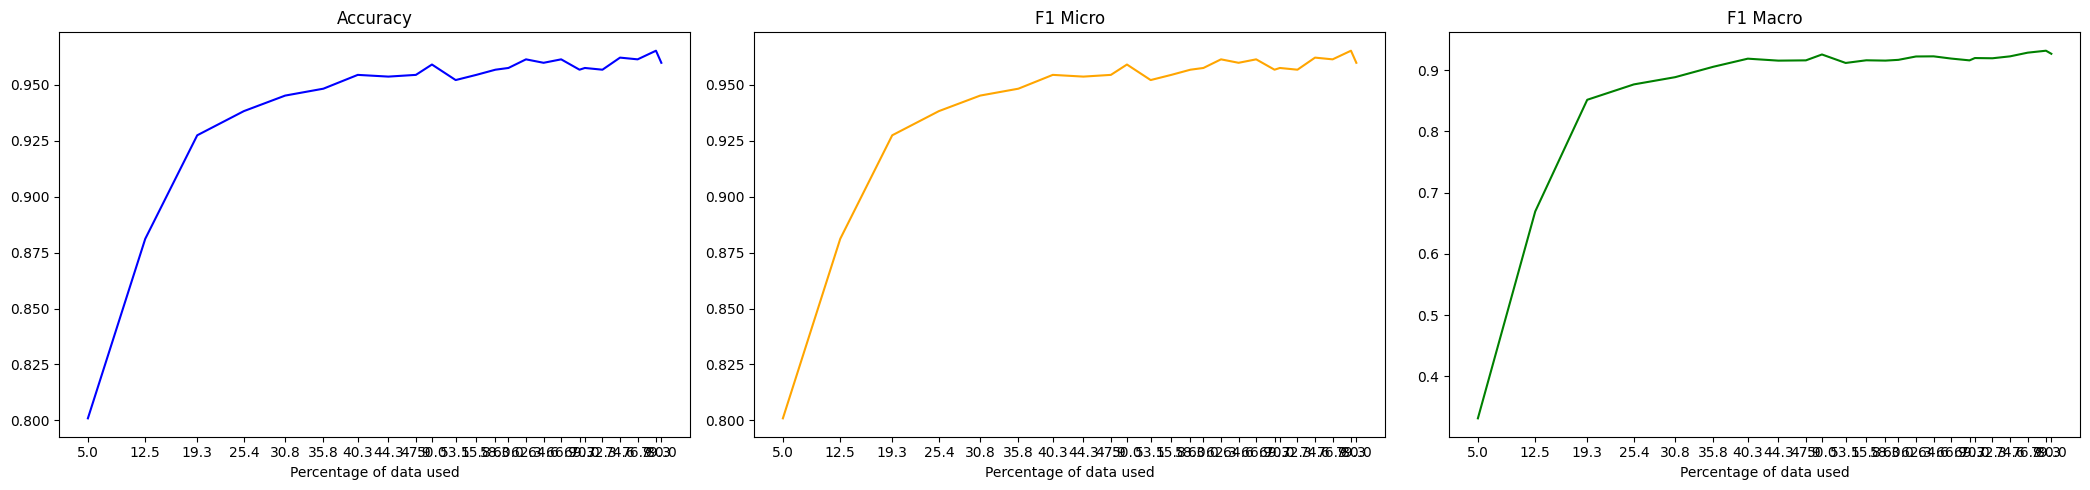

In [24]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6791, Accuracy: 0.7746, F1 Micro: 0.8722, F1 Macro: 0.8703
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5752, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.512, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4609, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4635, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4127, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3898, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4151, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.8159, Accuracy: 0.3333, F1 Micro: 0.3333, F1 Macro: 0.25
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6264, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5442, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5154, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4038, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3617, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3192, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2942, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3391, Accuracy: 0.66

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6192, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4908, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4511, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4285, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4123, Accuracy: 0.8006, F1 Micro: 0.8879, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3981, Accuracy: 0.8244, F1 Micro: 0.8991, F1 Macro: 0.8977
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.341, Accuracy: 0.8281, F1 Micro: 0.9006, F1 Macro: 0.8989
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.294, Accuracy: 0.8579, F1 Micro: 0.9159, F1 Macro: 0.9148
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7227, Accuracy: 0.6845, F1 Micro: 0.6845, F1 Macro: 0.4064
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6022, Accuracy: 0.6845, F1 Micro: 0.6845, F1 Macro: 0.4064
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5799, Accuracy: 0.6964, F1 Micro: 0.6964, F1 Macro: 0.4456
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4987, Accuracy: 0.7321, F1 Micro: 0.7321, F1 Macro: 0.5805
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3989, Accuracy: 0.8452, F1 Micro: 0.8452, F1 Macro: 0.7968
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3188, Accuracy: 0.9226, F1 Micro: 0.9226, F1 Macro: 0.908
Epoch 7/10, Train Loss: 0.1785, Accuracy: 0.881, F1 Micro: 0.881, F1 Macro: 0.8523
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1737, Accuracy: 0.9345, F1 Micro: 0.9345, F1 Macro: 0.923
Epoch 9/10, Train Loss: 0.1395, Accuracy: 0.8929, F1 Micro: 0.8929, F1 Macro: 0.8688
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5877, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.501, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4877, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4527, Accuracy: 0.7984, F1 Micro: 0.8863, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4162, Accuracy: 0.8192, F1 Micro: 0.8959, F1 Macro: 0.8939
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3563, Accuracy: 0.8512, F1 Micro: 0.912, F1 Macro: 0.9099
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3112, Accuracy: 0.8862, F1 Micro: 0.9309, F1 Macro: 0.9285
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2548, Accuracy: 0.9167, F1 Micro: 0.9493, F1 Macro: 0.9475
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6131, Accuracy: 0.6652, F1 Micro: 0.6652, F1 Macro: 0.3995
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4915, Accuracy: 0.7376, F1 Micro: 0.7376, F1 Macro: 0.6252
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.299, Accuracy: 0.8959, F1 Micro: 0.8959, F1 Macro: 0.8836
Epoch 4/10, Train Loss: 0.213, Accuracy: 0.8507, F1 Micro: 0.8507, F1 Macro: 0.824
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1754, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9108
Epoch 6/10, Train Loss: 0.1326, Accuracy: 0.8824, F1 Micro: 0.8824, F1 Macro: 0.8651
Epoch 7/10, Train Loss: 0.1317, Accuracy: 0.9095, F1 Micro: 0.9095, F1 Macro: 0.8997
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.8944
Epoch 9/10, Train Loss: 0.0884, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.889
Epoch 10/10, Train Loss: 0.0994, Accuracy: 0.8869, F1 Micro: 0.8869, F1 Macro: 0.8717

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5722, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.499, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4657, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.44, Accuracy: 0.8118, F1 Micro: 0.8922, F1 Macro: 0.8906
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3755, Accuracy: 0.8504, F1 Micro: 0.9109, F1 Macro: 0.9087
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3332, Accuracy: 0.9025, F1 Micro: 0.9406, F1 Macro: 0.9386
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2709, Accuracy: 0.9375, F1 Micro: 0.9613, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2162, Accuracy: 0.9412, F1 Micro: 0.9634, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6753, Accuracy: 0.6567, F1 Micro: 0.6567, F1 Macro: 0.3964
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4893, Accuracy: 0.7725, F1 Micro: 0.7725, F1 Macro: 0.7073
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3324, Accuracy: 0.897, F1 Micro: 0.897, F1 Macro: 0.8904
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2174, Accuracy: 0.9227, F1 Micro: 0.9227, F1 Macro: 0.9167
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1376, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9239
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1419, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9234
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0996, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9239
Epoch 8/10, Train Loss: 0.0828, Accuracy: 0.9227, F1 Micro: 0.9227, F1 Macro: 0.9127
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0985, Accuracy: 0.9313, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5685, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4831, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.466, Accuracy: 0.8006, F1 Micro: 0.8875, F1 Macro: 0.8859
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3988, Accuracy: 0.8423, F1 Micro: 0.9078, F1 Macro: 0.9059
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3346, Accuracy: 0.9025, F1 Micro: 0.9404, F1 Macro: 0.9384
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2713, Accuracy: 0.9345, F1 Micro: 0.9593, F1 Macro: 0.9576
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2275, Accuracy: 0.9449, F1 Micro: 0.9655, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1691, Accuracy: 0.9479, F1 Micro: 0.9674, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6339, Accuracy: 0.7231, F1 Micro: 0.7231, F1 Macro: 0.5746
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4926, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.8971
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3119, Accuracy: 0.9256, F1 Micro: 0.9256, F1 Macro: 0.9175
Epoch 4/10, Train Loss: 0.2609, Accuracy: 0.9215, F1 Micro: 0.9215, F1 Macro: 0.9092
Epoch 5/10, Train Loss: 0.2169, Accuracy: 0.9174, F1 Micro: 0.9174, F1 Macro: 0.9048
Epoch 6/10, Train Loss: 0.1385, Accuracy: 0.9215, F1 Micro: 0.9215, F1 Macro: 0.915
Epoch 7/10, Train Loss: 0.1468, Accuracy: 0.9215, F1 Micro: 0.9215, F1 Macro: 0.9098
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1202, Accuracy: 0.9298, F1 Micro: 0.9298, F1 Macro: 0.9231
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1532, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9362
Epoch 10/10, Train Loss: 0.0709, Accuracy: 0.938, F1 Micro: 0.938, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5571, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4732, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4404, Accuracy: 0.8237, F1 Micro: 0.8994, F1 Macro: 0.8981
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3632, Accuracy: 0.9018, F1 Micro: 0.9398, F1 Macro: 0.9369
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2699, Accuracy: 0.9435, F1 Micro: 0.9648, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.215, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1643, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1231, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6302, Accuracy: 0.8182, F1 Micro: 0.8182, F1 Macro: 0.7963
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4889, Accuracy: 0.8933, F1 Micro: 0.8933, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3057, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.9142
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2385, Accuracy: 0.9565, F1 Micro: 0.9565, F1 Macro: 0.9514
Epoch 5/10, Train Loss: 0.2234, Accuracy: 0.9526, F1 Micro: 0.9526, F1 Macro: 0.9474
Epoch 6/10, Train Loss: 0.1835, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9307
Epoch 7/10, Train Loss: 0.1633, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9317
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1361, Accuracy: 0.9605, F1 Micro: 0.9605, F1 Macro: 0.9554
Epoch 9/10, Train Loss: 0.1033, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9408
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0807, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5528, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4961, Accuracy: 0.7984, F1 Micro: 0.8866, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4177, Accuracy: 0.8504, F1 Micro: 0.9113, F1 Macro: 0.9095
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3359, Accuracy: 0.9115, F1 Micro: 0.9454, F1 Macro: 0.9432
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2467, Accuracy: 0.9472, F1 Micro: 0.967, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1929, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9721
Epoch 7/10, Train Loss: 0.1536, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9717
Epoch 8/10, Train Loss: 0.1221, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.971
Epoch 9/10, Train Loss: 0.1036, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9713
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6389, Accuracy: 0.7765, F1 Micro: 0.7765, F1 Macro: 0.7129
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4012, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9348
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3121, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9393
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1837, Accuracy: 0.9608, F1 Micro: 0.9608, F1 Macro: 0.9564
Epoch 5/10, Train Loss: 0.1793, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.915
Epoch 6/10, Train Loss: 0.1378, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9332
Epoch 7/10, Train Loss: 0.1398, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9313
Epoch 8/10, Train Loss: 0.0934, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9396
Epoch 9/10, Train Loss: 0.095, Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.9474
Epoch 10/10, Train Loss: 0.108, Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.9467

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5541, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4802, Accuracy: 0.8021, F1 Micro: 0.8883, F1 Macro: 0.8869
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4027, Accuracy: 0.8661, F1 Micro: 0.9201, F1 Macro: 0.918
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3088, Accuracy: 0.9338, F1 Micro: 0.959, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2276, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1679, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9721
Epoch 7/10, Train Loss: 0.136, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1053, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0871, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6421, Accuracy: 0.8088, F1 Micro: 0.8088, F1 Macro: 0.77
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4162, Accuracy: 0.9482, F1 Micro: 0.9482, F1 Macro: 0.9427
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2837, Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.9472
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2012, Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.9478
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1291, Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.9475
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1295, Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.9472
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0921, Accuracy: 0.9602, F1 Micro: 0.9602, F1 Macro: 0.9558
Epoch 8/10, Train Loss: 0.0908, Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.946
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0958, Accuracy: 0.9641, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5431, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4754, Accuracy: 0.808, F1 Micro: 0.8909, F1 Macro: 0.8895
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3824, Accuracy: 0.9129, F1 Micro: 0.9473, F1 Macro: 0.9462
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2723, Accuracy: 0.9531, F1 Micro: 0.971, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1955, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9707
Epoch 6/10, Train Loss: 0.148, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9699
Epoch 7/10, Train Loss: 0.1109, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0944, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0779, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5884, Accuracy: 0.876, F1 Micro: 0.876, F1 Macro: 0.8622
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3449, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.9022
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3046, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9426
Epoch 4/10, Train Loss: 0.2037, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9221
Epoch 5/10, Train Loss: 0.2218, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9372
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.166, Accuracy: 0.96, F1 Micro: 0.96, F1 Macro: 0.9562
Epoch 7/10, Train Loss: 0.1332, Accuracy: 0.94, F1 Micro: 0.94, F1 Macro: 0.9351
Epoch 8/10, Train Loss: 0.1149, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9474
Epoch 9/10, Train Loss: 0.0985, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9468
Epoch 10/10, Train Loss: 0.1095, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9185

Sentiment analysis accuracy: 0.96, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5558, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4607, Accuracy: 0.7984, F1 Micro: 0.8868, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3714, Accuracy: 0.9077, F1 Micro: 0.944, F1 Macro: 0.9429
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2726, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1977, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9728
Epoch 6/10, Train Loss: 0.15, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1116, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0951, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0784, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6104, Accuracy: 0.852, F1 Micro: 0.852, F1 Macro: 0.8282
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.347, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9253
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2721, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9468
Epoch 4/10, Train Loss: 0.2009, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.938
Epoch 5/10, Train Loss: 0.1514, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9215
Epoch 6/10, Train Loss: 0.1558, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9416
Epoch 7/10, Train Loss: 0.1114, Accuracy: 0.936, F1 Micro: 0.936, F1 Macro: 0.9302
Epoch 8/10, Train Loss: 0.0744, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9207
Epoch 9/10, Train Loss: 0.0885, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9173
Epoch 10/10, Train Loss: 0.0732, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9257

Sentiment analysis accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9468
 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5406, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4663, Accuracy: 0.8058, F1 Micro: 0.8893, F1 Macro: 0.8874
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3714, Accuracy: 0.9092, F1 Micro: 0.945, F1 Macro: 0.9436
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.26, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1886, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1417, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1035, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0902, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9753
Epoch 9/10, Train Loss: 0.0689, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6002, Accuracy: 0.8775, F1 Micro: 0.8775, F1 Macro: 0.8578
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3022, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9352
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2608, Accuracy: 0.9565, F1 Micro: 0.9565, F1 Macro: 0.952
Epoch 4/10, Train Loss: 0.2044, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.9396
Epoch 5/10, Train Loss: 0.1617, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9438
Epoch 6/10, Train Loss: 0.1155, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9415
Epoch 7/10, Train Loss: 0.0843, Accuracy: 0.9526, F1 Micro: 0.9526, F1 Macro: 0.9477
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.092, Accuracy: 0.9565, F1 Micro: 0.9565, F1 Macro: 0.9525
Epoch 9/10, Train Loss: 0.0779, Accuracy: 0.9526, F1 Micro: 0.9526, F1 Macro: 0.9468
Epoch 10/10, Train Loss: 0.0502, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.9376

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5419, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4602, Accuracy: 0.8348, F1 Micro: 0.9044, F1 Macro: 0.9029
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3431, Accuracy: 0.9323, F1 Micro: 0.9586, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2425, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9759
Epoch 5/10, Train Loss: 0.1772, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1328, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Epoch 7/10, Train Loss: 0.1077, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9749
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9736
Epoch 9/10, Train Loss: 0.0719, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9737
Epoch 10/10, Train Loss: 0.0614, Accuracy: 0.9635, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5455, Accuracy: 0.8937, F1 Micro: 0.8937, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2852, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9173
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1978, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9301
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9528, F1 Micro: 0.9528, F1 Macro: 0.9466
Epoch 5/10, Train Loss: 0.129, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9255
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9366
Epoch 7/10, Train Loss: 0.1179, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9222
Epoch 8/10, Train Loss: 0.0687, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9209
Epoch 9/10, Train Loss: 0.0667, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.937
Epoch 10/10, Train Loss: 0.075, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9251

Sentiment analysis accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.541, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4399, Accuracy: 0.8609, F1 Micro: 0.9176, F1 Macro: 0.9157
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3283, Accuracy: 0.9457, F1 Micro: 0.9663, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2262, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1671, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9742
Epoch 6/10, Train Loss: 0.1227, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0976, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0787, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9762
Epoch 9/10, Train Loss: 0.0649, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5734, Accuracy: 0.9016, F1 Micro: 0.9016, F1 Macro: 0.8953
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3, Accuracy: 0.9426, F1 Micro: 0.9426, F1 Macro: 0.9375
Epoch 3/10, Train Loss: 0.1827, Accuracy: 0.9221, F1 Micro: 0.9221, F1 Macro: 0.9114
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.909
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1626, Accuracy: 0.9426, F1 Micro: 0.9426, F1 Macro: 0.9378
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.9426, F1 Micro: 0.9426, F1 Macro: 0.9378
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1041, Accuracy: 0.9631, F1 Micro: 0.9631, F1 Macro: 0.9593
Epoch 8/10, Train Loss: 0.0925, Accuracy: 0.9467, F1 Micro: 0.9467, F1 Macro: 0.9421
Epoch 9/10, Train Loss: 0.0645, Accuracy: 0.9467, F1 Micro: 0.9467, F1 Macro: 0.9408
Epoch 10/10, Train Loss: 0.071, Accuracy: 0.959, F1 Micro: 0.959, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5274, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4371, Accuracy: 0.869, F1 Micro: 0.9214, F1 Macro: 0.9196
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3135, Accuracy: 0.9412, F1 Micro: 0.9634, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2173, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1572, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.974
Epoch 6/10, Train Loss: 0.1171, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0919, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9764
Epoch 8/10, Train Loss: 0.0776, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5707, Accuracy: 0.874, F1 Micro: 0.874, F1 Macro: 0.8594
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2922, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9158
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1908, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9343
Epoch 4/10, Train Loss: 0.1483, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9218
Epoch 5/10, Train Loss: 0.1337, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9255
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.9488, F1 Micro: 0.9488, F1 Macro: 0.9433
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0863, Accuracy: 0.9488, F1 Micro: 0.9488, F1 Macro: 0.9436
Epoch 8/10, Train Loss: 0.0973, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9315
Epoch 9/10, Train Loss: 0.0745, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9388
Epoch 10/10, Train Loss: 0.0534, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5339, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4339, Accuracy: 0.8973, F1 Micro: 0.9383, F1 Macro: 0.9367
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3023, Accuracy: 0.9479, F1 Micro: 0.9676, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2044, Accuracy: 0.9621, F1 Micro: 0.9764, F1 Macro: 0.9755
Epoch 5/10, Train Loss: 0.1467, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1075, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9784
Epoch 7/10, Train Loss: 0.0858, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9729
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9756
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Epoch 10/10, Train Loss: 0.0533, Accuracy: 0.9628, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5439, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8935
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3102, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9159
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2098, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9348
Epoch 4/10, Train Loss: 0.1172, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9306
Epoch 5/10, Train Loss: 0.1263, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.931
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9228
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0945, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9379
Epoch 8/10, Train Loss: 0.0749, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9344
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0611, Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.9471
Epoch 10/10, Train Loss: 0.0536, Accuracy: 0.9294, F1 Micro: 0.9294, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5401, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4381, Accuracy: 0.8705, F1 Micro: 0.9231, F1 Macro: 0.9215
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.309, Accuracy: 0.9501, F1 Micro: 0.9692, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2002, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9761
Epoch 5/10, Train Loss: 0.1471, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9728
Epoch 6/10, Train Loss: 0.1133, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.973
Epoch 7/10, Train Loss: 0.0946, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9729
Epoch 8/10, Train Loss: 0.0788, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0597, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0547, Accuracy: 0.9658, F1 Mi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5133, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8911
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2754, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9092
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.238, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9324
Epoch 4/10, Train Loss: 0.1839, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.921
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1712, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9364
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.131, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9358
Epoch 7/10, Train Loss: 0.1069, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9327
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.9482
Epoch 9/10, Train Loss: 0.0698, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9276
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.536, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4245, Accuracy: 0.8929, F1 Micro: 0.9358, F1 Macro: 0.9344
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2783, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1956, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Epoch 5/10, Train Loss: 0.139, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.972
Epoch 6/10, Train Loss: 0.1096, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9711
Epoch 7/10, Train Loss: 0.0866, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9748
Epoch 8/10, Train Loss: 0.0692, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.972
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9723
Epoch 10/10, Train Loss: 0.0491, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9749

Aspect

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5409, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8932
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2839, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.927
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1644, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9235
Epoch 4/10, Train Loss: 0.1512, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9187
Epoch 5/10, Train Loss: 0.0923, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.9143
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1205, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.927
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0653, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9249
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0959, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9295
Epoch 9/10, Train Loss: 0.0904, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9254
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5333, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4206, Accuracy: 0.9033, F1 Micro: 0.9408, F1 Macro: 0.9383
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2687, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1826, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1315, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1018, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9762
Epoch 7/10, Train Loss: 0.085, Accuracy: 0.9606, F1 Micro: 0.9749, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0703, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.9789
Epoch 9/10, Train Loss: 0.0604, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5679, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.9117
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.277, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9425
Epoch 3/10, Train Loss: 0.2069, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.935
Epoch 4/10, Train Loss: 0.1459, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9264
Epoch 5/10, Train Loss: 0.1243, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9386
Epoch 6/10, Train Loss: 0.133, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9226
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1066, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9434
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1021, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9434
Epoch 9/10, Train Loss: 0.0705, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9305
Epoch 10/10, Train Loss: 0.076, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9382

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5323, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.416, Accuracy: 0.9144, F1 Micro: 0.9481, F1 Macro: 0.9464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2712, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1789, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1319, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9771
Epoch 6/10, Train Loss: 0.1024, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9747
Epoch 7/10, Train Loss: 0.0781, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9752
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9748
Epoch 9/10, Train Loss: 0.0544, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5048, Accuracy: 0.9182, F1 Micro: 0.9182, F1 Macro: 0.9105
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2687, Accuracy: 0.9182, F1 Micro: 0.9182, F1 Macro: 0.9101
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1819, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9376
Epoch 4/10, Train Loss: 0.1504, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9209
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9209
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1065, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9369
Epoch 7/10, Train Loss: 0.1066, Accuracy: 0.9257, F1 Micro: 0.9257, F1 Macro: 0.9178
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0667, Accuracy: 0.9591, F1 Micro: 0.9591, F1 Macro: 0.9534
Epoch 9/10, Train Loss: 0.0831, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.932
Epoch 10/10, Train Loss: 0.082, Accuracy: 0.9517, F1 Micro: 0.9517, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5276, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4104, Accuracy: 0.9234, F1 Micro: 0.9533, F1 Macro: 0.9518
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.262, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1775, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9737
Epoch 5/10, Train Loss: 0.1327, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0829, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9783
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.0519, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9752
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.524, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9111
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2247, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9233
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2156, Accuracy: 0.9528, F1 Micro: 0.9528, F1 Macro: 0.9478
Epoch 4/10, Train Loss: 0.1391, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9237
Epoch 5/10, Train Loss: 0.1362, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9346
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9388
Epoch 7/10, Train Loss: 0.0923, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.9067
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9148
Epoch 9/10, Train Loss: 0.0618, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9226
Epoch 10/10, Train Loss: 0.0412, Accuracy: 0.9488, F1 Micro: 0.9488, F1 Macro: 0.9433

Sentiment analysis accuracy: 0.9528, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5261, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4098, Accuracy: 0.9234, F1 Micro: 0.9532, F1 Macro: 0.9515
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.252, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9708
Epoch 4/10, Train Loss: 0.1647, Accuracy: 0.9554, F1 Micro: 0.9718, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1229, Accuracy: 0.9673, F1 Micro: 0.9796, F1 Macro: 0.9787
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9739
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9773
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.9606, F1 Micro: 0.975, F1 Macro: 0.9727
Epoch 9/10, Train Loss: 0.0526, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9747
Epoch 10/10, Train Loss: 0.0485, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9777

Aspe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4981, Accuracy: 0.9306, F1 Micro: 0.9306, F1 Macro: 0.9232
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2293, Accuracy: 0.9592, F1 Micro: 0.9592, F1 Macro: 0.9552
Epoch 3/10, Train Loss: 0.1567, Accuracy: 0.9429, F1 Micro: 0.9429, F1 Macro: 0.9379
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1139, Accuracy: 0.9592, F1 Micro: 0.9592, F1 Macro: 0.9552
Epoch 5/10, Train Loss: 0.0768, Accuracy: 0.9469, F1 Micro: 0.9469, F1 Macro: 0.9419
Epoch 6/10, Train Loss: 0.0845, Accuracy: 0.9429, F1 Micro: 0.9429, F1 Macro: 0.9379
Epoch 7/10, Train Loss: 0.0836, Accuracy: 0.9388, F1 Micro: 0.9388, F1 Macro: 0.9319
Epoch 8/10, Train Loss: 0.057, Accuracy: 0.9429, F1 Micro: 0.9429, F1 Macro: 0.935
Epoch 9/10, Train Loss: 0.0639, Accuracy: 0.9347, F1 Micro: 0.9347, F1 Macro: 0.9283
Epoch 10/10, Train Loss: 0.0513, Accuracy: 0.9388, F1 Micro: 0.9388, F1 Macro: 0.9333

Sentiment analysis accuracy: 0.9592, F1 Micro: 0.95

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5257, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3947, Accuracy: 0.9196, F1 Micro: 0.9503, F1 Macro: 0.9482
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2512, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9743
Epoch 5/10, Train Loss: 0.1271, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0969, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9756
Epoch 7/10, Train Loss: 0.0758, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0655, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Epoch 9/10, Train Loss: 0.0493, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9749
Higher F1 achieved, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4902, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.9035
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2074, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9269
Epoch 3/10, Train Loss: 0.1595, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.924
Epoch 4/10, Train Loss: 0.1321, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9199
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1188, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9362
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0862, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.94
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.9535, F1 Micro: 0.9535, F1 Macro: 0.9485
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9148
Epoch 9/10, Train Loss: 0.1033, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9133
Epoch 10/10, Train Loss: 0.0691, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5293, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3907, Accuracy: 0.9286, F1 Micro: 0.956, F1 Macro: 0.9544
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2367, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1625, Accuracy: 0.965, F1 Micro: 0.9782, F1 Macro: 0.9774
Epoch 5/10, Train Loss: 0.1195, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9744
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0746, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Epoch 8/10, Train Loss: 0.0644, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9784
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0522, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9792
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4717, Accuracy: 0.8774, F1 Micro: 0.8774, F1 Macro: 0.8698
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2173, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.9086
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1658, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9441
Epoch 4/10, Train Loss: 0.1573, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9241
Epoch 5/10, Train Loss: 0.1449, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9148
Epoch 6/10, Train Loss: 0.0935, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9224
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9393
Epoch 8/10, Train Loss: 0.0809, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9281
Epoch 9/10, Train Loss: 0.0759, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8913
Epoch 10/10, Train Loss: 0.0525, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9161

Sentiment analysis accuracy: 0.9502, F1 Micro: 0.9502,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5244, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.403, Accuracy: 0.9204, F1 Micro: 0.9513, F1 Macro: 0.9494
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2515, Accuracy: 0.9554, F1 Micro: 0.9723, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1711, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1286, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9776
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1056, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9797
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9785
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.475, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9355
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2515, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.939
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.143, Accuracy: 0.9535, F1 Micro: 0.9535, F1 Macro: 0.9488
Epoch 4/10, Train Loss: 0.1179, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.9403
Epoch 5/10, Train Loss: 0.1376, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9287
Epoch 6/10, Train Loss: 0.1102, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9348
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0847, Accuracy: 0.9535, F1 Micro: 0.9535, F1 Macro: 0.9488
Epoch 8/10, Train Loss: 0.0584, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.94
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0671, Accuracy: 0.9729, F1 Micro: 0.9729, F1 Macro: 0.9692
Epoch 10/10, Train Loss: 0.0363, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Mac

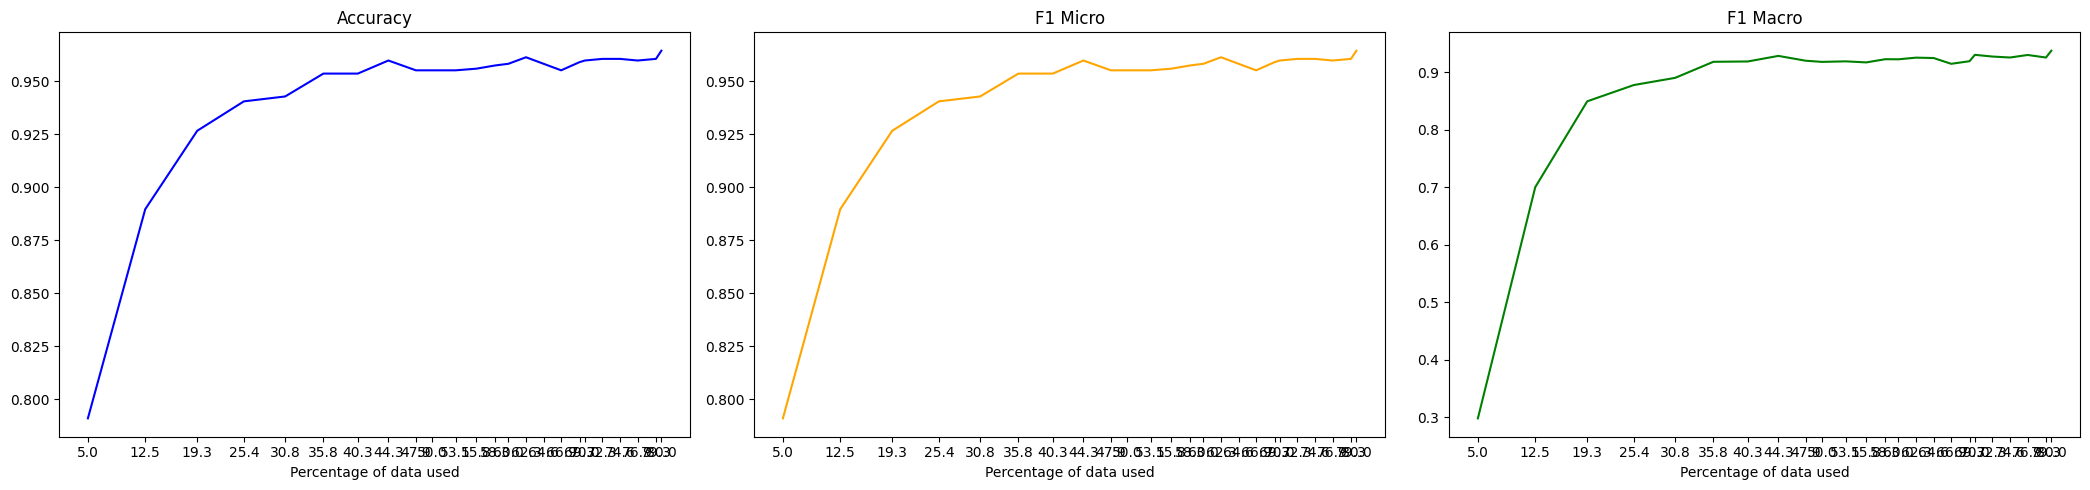

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6456, Accuracy: 0.7865, F1 Micro: 0.8804, F1 Macro: 0.8788
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5639, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5346, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5259, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4788, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 6/10, Train Loss: 0.477, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 7/10, Train Loss: 0.4707, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4588, Accuracy: 0.7909, F1 Micro: 0.883, F1 Macro: 0.8814
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.4215, Accuracy: 0.7932, F1 Micro: 0.8839, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7056, Accuracy: 0.44, F1 Micro: 0.44, F1 Macro: 0.4318
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5997, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5241, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5185, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.494, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4806, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4617, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.422, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3873, Accuracy: 0.84, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6192, Accuracy: 0.782, F1 Micro: 0.8763, F1 Macro: 0.873
Epoch 2/10, Train Loss: 0.535, Accuracy: 0.7775, F1 Micro: 0.8743, F1 Macro: 0.8713
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5001, Accuracy: 0.7879, F1 Micro: 0.8813, F1 Macro: 0.8797
Epoch 4/10, Train Loss: 0.5051, Accuracy: 0.7842, F1 Micro: 0.8776, F1 Macro: 0.8746
Epoch 5/10, Train Loss: 0.4748, Accuracy: 0.7924, F1 Micro: 0.8809, F1 Macro: 0.8774
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4241, Accuracy: 0.8051, F1 Micro: 0.8871, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.383, Accuracy: 0.8304, F1 Micro: 0.9, F1 Macro: 0.8965
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3486, Accuracy: 0.8445, F1 Micro: 0.9069, F1 Macro: 0.9027
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2947, Accuracy: 0.8631, F1 Micro: 0.9172, F1 Macro: 0.9135
Higher F1 achieved, saving 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5225, Accuracy: 0.7653, F1 Micro: 0.7653, F1 Macro: 0.4335
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.573, Accuracy: 0.7653, F1 Micro: 0.7653, F1 Macro: 0.4335
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3291, Accuracy: 0.7653, F1 Micro: 0.7653, F1 Macro: 0.4335
Epoch 4/10, Train Loss: 0.3867, Accuracy: 0.7606, F1 Micro: 0.7606, F1 Macro: 0.432
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2958, Accuracy: 0.7746, F1 Micro: 0.7746, F1 Macro: 0.58
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2304, Accuracy: 0.8357, F1 Micro: 0.8357, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1722, Accuracy: 0.8451, F1 Micro: 0.8451, F1 Macro: 0.7829
Epoch 8/10, Train Loss: 0.1446, Accuracy: 0.8263, F1 Micro: 0.8263, F1 Macro: 0.753
Epoch 9/10, Train Loss: 0.1144, Accuracy: 0.8404, F1 Micro: 0.8404, F1 Macro: 0.8028
Epoch 10/10, Train Loss: 0.1203, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5842, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.4961, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4881, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4542, Accuracy: 0.7969, F1 Micro: 0.8855, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.434, Accuracy: 0.8155, F1 Micro: 0.8931, F1 Macro: 0.8908
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3795, Accuracy: 0.8452, F1 Micro: 0.9085, F1 Macro: 0.9059
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.325, Accuracy: 0.8876, F1 Micro: 0.9316, F1 Macro: 0.9299
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2659, Accuracy: 0.904, F1 Micro: 0.9409, F1 Macro: 0.9389
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.221, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5684, Accuracy: 0.6991, F1 Micro: 0.6991, F1 Macro: 0.4115
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.506, Accuracy: 0.6991, F1 Micro: 0.6991, F1 Macro: 0.4115
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4286, Accuracy: 0.8186, F1 Micro: 0.8186, F1 Macro: 0.7552
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3007, Accuracy: 0.8761, F1 Micro: 0.8761, F1 Macro: 0.854
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2196, Accuracy: 0.8761, F1 Micro: 0.8761, F1 Macro: 0.8594
Epoch 6/10, Train Loss: 0.208, Accuracy: 0.8717, F1 Micro: 0.8717, F1 Macro: 0.8441
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.136, Accuracy: 0.8982, F1 Micro: 0.8982, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1489, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8949
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1129, Accuracy: 0.9159, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5665, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.4913, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4847, Accuracy: 0.7924, F1 Micro: 0.8836, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4436, Accuracy: 0.8185, F1 Micro: 0.8953, F1 Macro: 0.8932
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3826, Accuracy: 0.8423, F1 Micro: 0.9082, F1 Macro: 0.9066
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3189, Accuracy: 0.8966, F1 Micro: 0.9364, F1 Macro: 0.9334
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2727, Accuracy: 0.9263, F1 Micro: 0.9541, F1 Macro: 0.9511
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2102, Accuracy: 0.9375, F1 Micro: 0.9611, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1716, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5952, Accuracy: 0.6778, F1 Micro: 0.6778, F1 Macro: 0.404
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5325, Accuracy: 0.8243, F1 Micro: 0.8243, F1 Macro: 0.7689
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3311, Accuracy: 0.8954, F1 Micro: 0.8954, F1 Macro: 0.8829
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2426, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1578, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9066
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1776, Accuracy: 0.9205, F1 Micro: 0.9205, F1 Macro: 0.9067
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1051, Accuracy: 0.9205, F1 Micro: 0.9205, F1 Macro: 0.9087
Epoch 8/10, Train Loss: 0.0805, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9077
Epoch 9/10, Train Loss: 0.0746, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8915
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5559, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.5018, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4587, Accuracy: 0.7976, F1 Micro: 0.8862, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3977, Accuracy: 0.8542, F1 Micro: 0.914, F1 Macro: 0.9123
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.326, Accuracy: 0.9085, F1 Micro: 0.9439, F1 Macro: 0.9416
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2623, Accuracy: 0.936, F1 Micro: 0.9601, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2086, Accuracy: 0.9487, F1 Micro: 0.968, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1552, Accuracy: 0.9509, F1 Micro: 0.9693, F1 Macro: 0.9673
Epoch 9/10, Train Loss: 0.1376, Accuracy: 0.9449, F1 Micro: 0.9651, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6446, Accuracy: 0.7333, F1 Micro: 0.7333, F1 Macro: 0.5893
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5261, Accuracy: 0.8745, F1 Micro: 0.8745, F1 Macro: 0.8596
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3208, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.9046
Epoch 4/10, Train Loss: 0.2601, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.9005
Epoch 5/10, Train Loss: 0.1291, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8867
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1763, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9065
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1137, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9076
Epoch 8/10, Train Loss: 0.0882, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.9051
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0992, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9163
Epoch 10/10, Train Loss: 0.1029, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5511, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4806, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4323, Accuracy: 0.8155, F1 Micro: 0.8939, F1 Macro: 0.892
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3685, Accuracy: 0.8899, F1 Micro: 0.9339, F1 Macro: 0.932
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2813, Accuracy: 0.9397, F1 Micro: 0.9629, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.206, Accuracy: 0.9472, F1 Micro: 0.9672, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1561, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1227, Accuracy: 0.9524, F1 Micro: 0.9702, F1 Macro: 0.9681
Epoch 9/10, Train Loss: 0.1082, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6365, Accuracy: 0.7742, F1 Micro: 0.7742, F1 Macro: 0.7304
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5181, Accuracy: 0.879, F1 Micro: 0.879, F1 Macro: 0.8507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3634, Accuracy: 0.9395, F1 Micro: 0.9395, F1 Macro: 0.9331
Epoch 4/10, Train Loss: 0.2614, Accuracy: 0.9194, F1 Micro: 0.9194, F1 Macro: 0.9124
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.201, Accuracy: 0.9395, F1 Micro: 0.9395, F1 Macro: 0.9323
Epoch 6/10, Train Loss: 0.149, Accuracy: 0.9355, F1 Micro: 0.9355, F1 Macro: 0.9284
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1194, Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.9406
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1209, Accuracy: 0.9556, F1 Micro: 0.9556, F1 Macro: 0.9501
Epoch 9/10, Train Loss: 0.0928, Accuracy: 0.9395, F1 Micro: 0.9395, F1 Macro: 0.9334
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.532, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4734, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.43, Accuracy: 0.8356, F1 Micro: 0.9045, F1 Macro: 0.9026
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3431, Accuracy: 0.9159, F1 Micro: 0.9478, F1 Macro: 0.9447
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2581, Accuracy: 0.942, F1 Micro: 0.9635, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2045, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1489, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9713
Epoch 8/10, Train Loss: 0.1258, Accuracy: 0.9531, F1 Micro: 0.9706, F1 Macro: 0.9687
Epoch 9/10, Train Loss: 0.0999, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6417, Accuracy: 0.7833, F1 Micro: 0.7833, F1 Macro: 0.7705
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.458, Accuracy: 0.8859, F1 Micro: 0.8859, F1 Macro: 0.8775
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2937, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9284
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2444, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9313
Epoch 5/10, Train Loss: 0.2177, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9223
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1576, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9317
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1215, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9361
Epoch 8/10, Train Loss: 0.124, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9195
Epoch 9/10, Train Loss: 0.0845, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9276
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5371, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4918, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4225, Accuracy: 0.8631, F1 Micro: 0.9174, F1 Macro: 0.9142
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3264, Accuracy: 0.9375, F1 Micro: 0.961, F1 Macro: 0.9585
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2292, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9704
Epoch 6/10, Train Loss: 0.1766, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9697
Epoch 7/10, Train Loss: 0.1381, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1021, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0896, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6278, Accuracy: 0.8249, F1 Micro: 0.8249, F1 Macro: 0.7856
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4165, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.9069
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2649, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9198
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2099, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9288
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1651, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.935
Epoch 6/10, Train Loss: 0.1549, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.9077
Epoch 7/10, Train Loss: 0.1484, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9194
Epoch 8/10, Train Loss: 0.1115, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9309
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.113, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.935
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5465, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4971, Accuracy: 0.8043, F1 Micro: 0.8894, F1 Macro: 0.8879
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3939, Accuracy: 0.9107, F1 Micro: 0.9454, F1 Macro: 0.9431
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2904, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2032, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9726
Epoch 6/10, Train Loss: 0.1452, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1176, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0936, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Epoch 9/10, Train Loss: 0.077, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5887, Accuracy: 0.8224, F1 Micro: 0.8224, F1 Macro: 0.7905
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3703, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9366
Epoch 3/10, Train Loss: 0.2108, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9326
Epoch 4/10, Train Loss: 0.1966, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9289
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9401
Epoch 6/10, Train Loss: 0.1296, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.93
Epoch 7/10, Train Loss: 0.1049, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9319
Epoch 8/10, Train Loss: 0.0888, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9282
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9278
Epoch 10/10, Train Loss: 0.1, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9319

Sentiment analysis accuracy: 0.9459, F1 Micro: 0.9459,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5484, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4901, Accuracy: 0.7984, F1 Micro: 0.8866, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4013, Accuracy: 0.9018, F1 Micro: 0.94, F1 Macro: 0.9376
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2949, Accuracy: 0.9457, F1 Micro: 0.9661, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1963, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1489, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9735
Epoch 7/10, Train Loss: 0.1154, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0973, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9731
Epoch 9/10, Train Loss: 0.0804, Accuracy: 0.9576, F1 Micro: 0.9732, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5771, Accuracy: 0.845, F1 Micro: 0.845, F1 Macro: 0.8149
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3752, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9142
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2546, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.9393
Epoch 4/10, Train Loss: 0.2062, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9163
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.94
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.9386
Epoch 7/10, Train Loss: 0.0997, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9261
Epoch 8/10, Train Loss: 0.1082, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9273
Epoch 9/10, Train Loss: 0.078, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9228
Epoch 10/10, Train Loss: 0.0713, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5379, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4688, Accuracy: 0.8021, F1 Micro: 0.8875, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3833, Accuracy: 0.9182, F1 Micro: 0.9494, F1 Macro: 0.947
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2681, Accuracy: 0.9539, F1 Micro: 0.9715, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1849, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9752
Epoch 6/10, Train Loss: 0.1389, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1071, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9758
Epoch 8/10, Train Loss: 0.0933, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0702, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6175, Accuracy: 0.7638, F1 Micro: 0.7638, F1 Macro: 0.6867
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3837, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9274
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2428, Accuracy: 0.9528, F1 Micro: 0.9528, F1 Macro: 0.9476
Epoch 4/10, Train Loss: 0.1861, Accuracy: 0.9488, F1 Micro: 0.9488, F1 Macro: 0.9439
Epoch 5/10, Train Loss: 0.1711, Accuracy: 0.9488, F1 Micro: 0.9488, F1 Macro: 0.9439
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.9488, F1 Micro: 0.9488, F1 Macro: 0.9427
Epoch 7/10, Train Loss: 0.14, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9381
Epoch 8/10, Train Loss: 0.0906, Accuracy: 0.9488, F1 Micro: 0.9488, F1 Macro: 0.9439
Epoch 9/10, Train Loss: 0.092, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9356
Epoch 10/10, Train Loss: 0.0798, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.935

Sentiment analysis accuracy: 0.9528, F1 Micro: 0.9528,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5428, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4662, Accuracy: 0.811, F1 Micro: 0.8911, F1 Macro: 0.8892
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3559, Accuracy: 0.9256, F1 Micro: 0.9544, F1 Macro: 0.9525
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2495, Accuracy: 0.9464, F1 Micro: 0.967, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1766, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1292, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1033, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Epoch 8/10, Train Loss: 0.0869, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9739
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6031, Accuracy: 0.8659, F1 Micro: 0.8659, F1 Macro: 0.8449
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3701, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9245
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2214, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9372
Epoch 4/10, Train Loss: 0.1991, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9208
Epoch 5/10, Train Loss: 0.146, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9261
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1406, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9366
Epoch 7/10, Train Loss: 0.1328, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9165
Epoch 8/10, Train Loss: 0.1204, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9306
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0972, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9355
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0814, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5358, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4576, Accuracy: 0.8214, F1 Micro: 0.8963, F1 Macro: 0.8942
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3396, Accuracy: 0.933, F1 Micro: 0.9582, F1 Macro: 0.9556
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2341, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9706
Epoch 5/10, Train Loss: 0.1627, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.12, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0937, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.0765, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9729
Epoch 9/10, Train Loss: 0.0652, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6063, Accuracy: 0.8717, F1 Micro: 0.8717, F1 Macro: 0.8518
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3346, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9239
Epoch 3/10, Train Loss: 0.2541, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9137
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1849, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9331
Epoch 5/10, Train Loss: 0.1419, Accuracy: 0.9019, F1 Micro: 0.9019, F1 Macro: 0.8943
Epoch 6/10, Train Loss: 0.1639, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9172
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0975, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9327
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9311
Epoch 9/10, Train Loss: 0.0811, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9251
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.081, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5295, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4551, Accuracy: 0.8512, F1 Micro: 0.9117, F1 Macro: 0.9094
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3151, Accuracy: 0.939, F1 Micro: 0.9621, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2158, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1601, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1175, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Epoch 7/10, Train Loss: 0.0931, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9742
Epoch 9/10, Train Loss: 0.0586, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.514, Accuracy: 0.8931, F1 Micro: 0.8931, F1 Macro: 0.8815
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2618, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9198
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1975, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9353
Epoch 4/10, Train Loss: 0.1585, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9323
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1383, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.939
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1483, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.9398
Epoch 7/10, Train Loss: 0.1098, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9323
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1079, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.9442
Epoch 9/10, Train Loss: 0.0706, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9337
Epoch 10/10, Train Loss: 0.0789, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5346, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4529, Accuracy: 0.8467, F1 Micro: 0.9088, F1 Macro: 0.906
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3156, Accuracy: 0.9435, F1 Micro: 0.9649, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.206, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1402, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9743
Epoch 6/10, Train Loss: 0.108, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0875, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Epoch 8/10, Train Loss: 0.0723, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9732
Epoch 9/10, Train Loss: 0.057, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9744
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5345, Accuracy: 0.8927, F1 Micro: 0.8927, F1 Macro: 0.8747
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2803, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8968
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.199, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9362
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9348
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.158, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.94
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1302, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.94
Epoch 7/10, Train Loss: 0.1174, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9241
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1036, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9428
Epoch 9/10, Train Loss: 0.092, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9277
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5387, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4489, Accuracy: 0.8594, F1 Micro: 0.9168, F1 Macro: 0.9145
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.303, Accuracy: 0.9427, F1 Micro: 0.9644, F1 Macro: 0.9631
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.197, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1455, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1099, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9782
Epoch 8/10, Train Loss: 0.0676, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9742
Epoch 9/10, Train Loss: 0.0576, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5986, Accuracy: 0.8031, F1 Micro: 0.8031, F1 Macro: 0.7389
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3411, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9136
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1988, Accuracy: 0.9488, F1 Micro: 0.9488, F1 Macro: 0.9433
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1705, Accuracy: 0.9528, F1 Micro: 0.9528, F1 Macro: 0.9473
Epoch 5/10, Train Loss: 0.1319, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9308
Epoch 6/10, Train Loss: 0.1224, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.935
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1019, Accuracy: 0.9567, F1 Micro: 0.9567, F1 Macro: 0.9518
Epoch 8/10, Train Loss: 0.0893, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9263
Epoch 9/10, Train Loss: 0.0572, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9153
Epoch 10/10, Train Loss: 0.0892, Accuracy: 0.9291, F1 Micro: 0.9291, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5258, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4368, Accuracy: 0.8571, F1 Micro: 0.9163, F1 Macro: 0.9147
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3023, Accuracy: 0.9442, F1 Micro: 0.9652, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1918, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1356, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9763
Epoch 6/10, Train Loss: 0.1113, Accuracy: 0.9524, F1 Micro: 0.9698, F1 Macro: 0.9663
Epoch 7/10, Train Loss: 0.0939, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0698, Accuracy: 0.965, F1 Micro: 0.9782, F1 Macro: 0.977
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5565, Accuracy: 0.8975, F1 Micro: 0.8975, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2535, Accuracy: 0.9303, F1 Micro: 0.9303, F1 Macro: 0.9243
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1794, Accuracy: 0.9467, F1 Micro: 0.9467, F1 Macro: 0.9415
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9426, F1 Micro: 0.9426, F1 Macro: 0.9353
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1354, Accuracy: 0.959, F1 Micro: 0.959, F1 Macro: 0.9546
Epoch 6/10, Train Loss: 0.1112, Accuracy: 0.9549, F1 Micro: 0.9549, F1 Macro: 0.9499
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.9262, F1 Micro: 0.9262, F1 Macro: 0.914
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.9467, F1 Micro: 0.9467, F1 Macro: 0.9405
Epoch 9/10, Train Loss: 0.0803, Accuracy: 0.9426, F1 Micro: 0.9426, F1 Macro: 0.9368
Epoch 10/10, Train Loss: 0.1019, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9265

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5349, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4249, Accuracy: 0.9025, F1 Micro: 0.9405, F1 Macro: 0.9384
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2727, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1817, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1269, Accuracy: 0.9665, F1 Micro: 0.9791, F1 Macro: 0.978
Epoch 6/10, Train Loss: 0.1027, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Epoch 9/10, Train Loss: 0.0542, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9771
Epoch 10/10, Train Loss: 0.0466, Accuracy: 0.9665, F1 Mi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5429, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9137
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2848, Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.941
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2132, Accuracy: 0.9516, F1 Micro: 0.9516, F1 Macro: 0.9463
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1307, Accuracy: 0.9637, F1 Micro: 0.9637, F1 Macro: 0.9596
Epoch 5/10, Train Loss: 0.1289, Accuracy: 0.9597, F1 Micro: 0.9597, F1 Macro: 0.9553
Epoch 6/10, Train Loss: 0.0844, Accuracy: 0.9597, F1 Micro: 0.9597, F1 Macro: 0.955
Epoch 7/10, Train Loss: 0.0731, Accuracy: 0.9516, F1 Micro: 0.9516, F1 Macro: 0.9466
Epoch 8/10, Train Loss: 0.0688, Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.942
Epoch 9/10, Train Loss: 0.0591, Accuracy: 0.9315, F1 Micro: 0.9315, F1 Macro: 0.9208
Epoch 10/10, Train Loss: 0.0712, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.9362

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5303, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4281, Accuracy: 0.8824, F1 Micro: 0.9298, F1 Macro: 0.9279
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2822, Accuracy: 0.9464, F1 Micro: 0.9665, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1789, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9764
Epoch 6/10, Train Loss: 0.0972, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9718
Epoch 7/10, Train Loss: 0.0812, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9741
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9789
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4969, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9087
Epoch 2/10, Train Loss: 0.2834, Accuracy: 0.8977, F1 Micro: 0.8977, F1 Macro: 0.8902
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1799, Accuracy: 0.9242, F1 Micro: 0.9242, F1 Macro: 0.9174
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.15, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9369
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9282
Epoch 6/10, Train Loss: 0.114, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.921
Epoch 7/10, Train Loss: 0.0822, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9249
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1201, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.941
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.079, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.9396
Epoch 10/10, Train Loss: 0.0615, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5221, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.422, Accuracy: 0.8981, F1 Micro: 0.9376, F1 Macro: 0.9351
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2625, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1751, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1259, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.978
Epoch 6/10, Train Loss: 0.0981, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9755
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9778
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0607, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.98
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5031, Accuracy: 0.8755, F1 Micro: 0.8755, F1 Macro: 0.8675
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2362, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9113
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2055, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9194
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9194
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1266, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9357
Epoch 6/10, Train Loss: 0.101, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.9033
Epoch 7/10, Train Loss: 0.0935, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9226
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0911, Accuracy: 0.9533, F1 Micro: 0.9533, F1 Macro: 0.9479
Epoch 9/10, Train Loss: 0.0673, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9316
Epoch 10/10, Train Loss: 0.0392, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5258, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4104, Accuracy: 0.9085, F1 Micro: 0.9436, F1 Macro: 0.9403
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2487, Accuracy: 0.9449, F1 Micro: 0.9655, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1716, Accuracy: 0.9539, F1 Micro: 0.971, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0921, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9783
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9789
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.536, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8967
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.232, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9245
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1937, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9429
Epoch 4/10, Train Loss: 0.1382, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9273
Epoch 5/10, Train Loss: 0.1398, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.9067
Epoch 6/10, Train Loss: 0.1092, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9304
Epoch 7/10, Train Loss: 0.0867, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9387
Epoch 8/10, Train Loss: 0.0695, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9184
Epoch 9/10, Train Loss: 0.0582, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9376
Epoch 10/10, Train Loss: 0.0575, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9171

Sentiment analysis accuracy: 0.9492, F1 Micro: 0.94

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5339, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4085, Accuracy: 0.9018, F1 Micro: 0.9388, F1 Macro: 0.9345
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2562, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1277, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0947, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9769
Epoch 7/10, Train Loss: 0.078, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0493, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4544, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9057
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1964, Accuracy: 0.9251, F1 Micro: 0.9251, F1 Macro: 0.9162
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1636, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.921
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1379, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.9326
Epoch 5/10, Train Loss: 0.1084, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9286
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0755, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9363
Epoch 7/10, Train Loss: 0.0704, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.9322
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.8989, F1 Micro: 0.8989, F1 Macro: 0.8905
Epoch 9/10, Train Loss: 0.084, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.931
Epoch 10/10, Train Loss: 0.064, Accuracy: 0.9251, F1 Micro: 0.9251, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5196, Accuracy: 0.7954, F1 Micro: 0.8853, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4004, Accuracy: 0.9159, F1 Micro: 0.9483, F1 Macro: 0.9459
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2465, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1583, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1211, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9796
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.978
Epoch 7/10, Train Loss: 0.0758, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9791
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0573, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9795
Epoch 9/10, Train Loss: 0.0498, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.978
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4892, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9191
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2537, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9288
Epoch 3/10, Train Loss: 0.1761, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9172
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1338, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9317
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9251
Epoch 6/10, Train Loss: 0.0766, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9259
Epoch 7/10, Train Loss: 0.1115, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9251
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0703, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9372
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0506, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9361
Epoch 10/10, Train Loss: 0.057, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5194, Accuracy: 0.7924, F1 Micro: 0.882, F1 Macro: 0.8794
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4067, Accuracy: 0.9196, F1 Micro: 0.951, F1 Macro: 0.9494
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2587, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9784
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9786
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9772
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4731, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9103
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2337, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9283
Epoch 3/10, Train Loss: 0.1692, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9162
Epoch 4/10, Train Loss: 0.1374, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.9119
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1211, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.935
Epoch 6/10, Train Loss: 0.085, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9239
Epoch 7/10, Train Loss: 0.0856, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.925
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9317
Epoch 9/10, Train Loss: 0.0656, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9259
Epoch 10/10, Train Loss: 0.0372, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9218

Sentiment analysis accuracy: 0.9423, F1 Micro: 0.9423

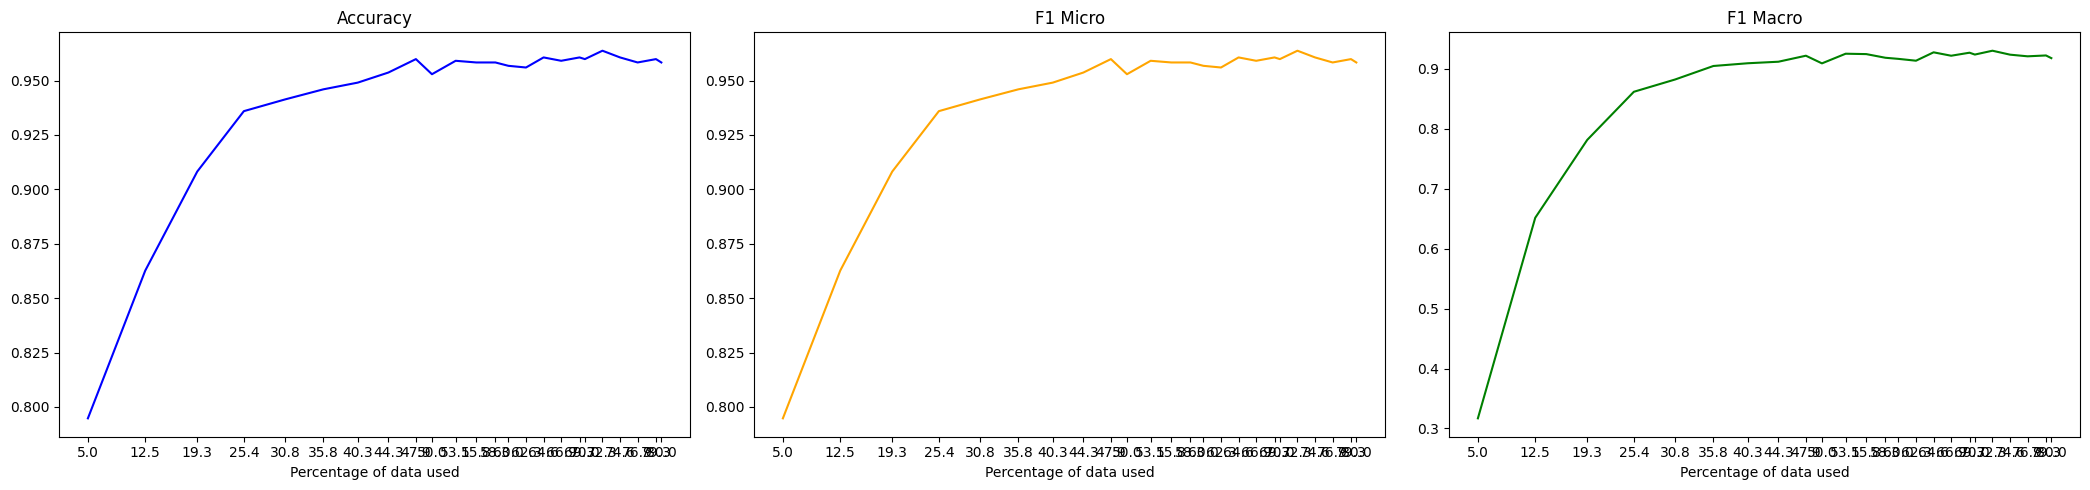

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6298, Accuracy: 0.7522, F1 Micro: 0.854, F1 Macro: 0.8362
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5654, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5262, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4783, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4582, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4326, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4132, Accuracy: 0.7924, F1 Micro: 0.8837, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4395, Accuracy: 0.7939, F1 Micro: 0.8842, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7142, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5719, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.6151, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5677, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5123, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.5138, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4932, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3579, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6127, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5046, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4848, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4985, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4552, Accuracy: 0.808, F1 Micro: 0.8912, F1 Macro: 0.89
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4116, Accuracy: 0.8192, F1 Micro: 0.8967, F1 Macro: 0.8957
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3835, Accuracy: 0.8408, F1 Micro: 0.9073, F1 Macro: 0.9064
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3501, Accuracy: 0.875, F1 Micro: 0.9259, F1 Macro: 0.9249
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7022, Accuracy: 0.6648, F1 Micro: 0.6648, F1 Macro: 0.3993
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6131, Accuracy: 0.6813, F1 Micro: 0.6813, F1 Macro: 0.4633
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.589, Accuracy: 0.8297, F1 Micro: 0.8297, F1 Macro: 0.7925
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4854, Accuracy: 0.8352, F1 Micro: 0.8352, F1 Macro: 0.7878
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4023, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.8815
Epoch 6/10, Train Loss: 0.2812, Accuracy: 0.8956, F1 Micro: 0.8956, F1 Macro: 0.8714
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2469, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9137
Epoch 8/10, Train Loss: 0.166, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.8935
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1392, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9384
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5938, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.522, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5117, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4894, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4555, Accuracy: 0.8125, F1 Micro: 0.8938, F1 Macro: 0.8925
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4071, Accuracy: 0.8534, F1 Micro: 0.9146, F1 Macro: 0.9135
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3292, Accuracy: 0.9062, F1 Micro: 0.9433, F1 Macro: 0.9414
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2775, Accuracy: 0.9301, F1 Micro: 0.9569, F1 Macro: 0.9551
Epoch 9/10, Train Loss: 0.2254, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6939, Accuracy: 0.6751, F1 Micro: 0.6751, F1 Macro: 0.403
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5961, Accuracy: 0.865, F1 Micro: 0.865, F1 Macro: 0.844
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4281, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9117
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3297, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9174
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2171, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.934
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2271, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9344
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1962, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.943
Epoch 8/10, Train Loss: 0.1819, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9385
Epoch 9/10, Train Loss: 0.1453, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9381
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5669, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5084, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4886, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4556, Accuracy: 0.8036, F1 Micro: 0.8894, F1 Macro: 0.888
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4078, Accuracy: 0.8408, F1 Micro: 0.9078, F1 Macro: 0.9069
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3468, Accuracy: 0.8996, F1 Micro: 0.9392, F1 Macro: 0.9372
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2867, Accuracy: 0.9323, F1 Micro: 0.958, F1 Macro: 0.9559
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2157, Accuracy: 0.9397, F1 Micro: 0.9624, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6706, Accuracy: 0.6914, F1 Micro: 0.6914, F1 Macro: 0.4653
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5996, Accuracy: 0.8765, F1 Micro: 0.8765, F1 Macro: 0.8602
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4085, Accuracy: 0.8765, F1 Micro: 0.8765, F1 Macro: 0.8694
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3203, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9211
Epoch 5/10, Train Loss: 0.2009, Accuracy: 0.9218, F1 Micro: 0.9218, F1 Macro: 0.9094
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1991, Accuracy: 0.9465, F1 Micro: 0.9465, F1 Macro: 0.9404
Epoch 7/10, Train Loss: 0.1925, Accuracy: 0.8765, F1 Micro: 0.8765, F1 Macro: 0.8694
Epoch 8/10, Train Loss: 0.1714, Accuracy: 0.9424, F1 Micro: 0.9424, F1 Macro: 0.9352
Epoch 9/10, Train Loss: 0.1195, Accuracy: 0.9342, F1 Micro: 0.9342, F1 Macro: 0.928
Epoch 10/10, Train Loss: 0.1102, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5633, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4981, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4724, Accuracy: 0.7984, F1 Micro: 0.8868, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4251, Accuracy: 0.8415, F1 Micro: 0.9079, F1 Macro: 0.9073
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3498, Accuracy: 0.8988, F1 Micro: 0.939, F1 Macro: 0.9374
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2816, Accuracy: 0.9301, F1 Micro: 0.9565, F1 Macro: 0.9546
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2095, Accuracy: 0.939, F1 Micro: 0.962, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1693, Accuracy: 0.9457, F1 Micro: 0.9661, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6692, Accuracy: 0.7137, F1 Micro: 0.7137, F1 Macro: 0.591
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5728, Accuracy: 0.8963, F1 Micro: 0.8963, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3367, Accuracy: 0.9212, F1 Micro: 0.9212, F1 Macro: 0.909
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2505, Accuracy: 0.9378, F1 Micro: 0.9378, F1 Macro: 0.9324
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1886, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9337
Epoch 6/10, Train Loss: 0.2052, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.9109
Epoch 7/10, Train Loss: 0.1151, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9256
Epoch 8/10, Train Loss: 0.1032, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.9067
Epoch 9/10, Train Loss: 0.1297, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.9109
Epoch 10/10, Train Loss: 0.0581, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5356, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4625, Accuracy: 0.7961, F1 Micro: 0.8856, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4362, Accuracy: 0.8289, F1 Micro: 0.902, F1 Macro: 0.9011
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3648, Accuracy: 0.881, F1 Micro: 0.929, F1 Macro: 0.9285
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2681, Accuracy: 0.9308, F1 Micro: 0.9571, F1 Macro: 0.9553
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2108, Accuracy: 0.9442, F1 Micro: 0.9651, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1487, Accuracy: 0.9539, F1 Micro: 0.9714, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.119, Accuracy: 0.9554, F1 Micro: 0.9723, F1 Macro: 0.9709
Epoch 9/10, Train Loss: 0.1017, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6707, Accuracy: 0.7431, F1 Micro: 0.7431, F1 Macro: 0.7384
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4787, Accuracy: 0.8063, F1 Micro: 0.8063, F1 Macro: 0.7997
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3347, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9249
Epoch 4/10, Train Loss: 0.2689, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.9088
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1714, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.938
Epoch 6/10, Train Loss: 0.1609, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.9133
Epoch 7/10, Train Loss: 0.1023, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.9088
Epoch 8/10, Train Loss: 0.0845, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9249
Epoch 9/10, Train Loss: 0.0997, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9207
Epoch 10/10, Train Loss: 0.0645, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9245

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5481, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4734, Accuracy: 0.7961, F1 Micro: 0.8856, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4256, Accuracy: 0.8393, F1 Micro: 0.9072, F1 Macro: 0.9064
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3497, Accuracy: 0.9211, F1 Micro: 0.9517, F1 Macro: 0.9497
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2496, Accuracy: 0.939, F1 Micro: 0.9619, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1798, Accuracy: 0.9494, F1 Micro: 0.9685, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1406, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1158, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6663, Accuracy: 0.7733, F1 Micro: 0.7733, F1 Macro: 0.7692
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4927, Accuracy: 0.919, F1 Micro: 0.919, F1 Macro: 0.9093
Epoch 3/10, Train Loss: 0.3018, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.897
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2764, Accuracy: 0.9433, F1 Micro: 0.9433, F1 Macro: 0.9382
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2035, Accuracy: 0.9555, F1 Micro: 0.9555, F1 Macro: 0.9508
Epoch 6/10, Train Loss: 0.1366, Accuracy: 0.9312, F1 Micro: 0.9312, F1 Macro: 0.9212
Epoch 7/10, Train Loss: 0.1032, Accuracy: 0.9352, F1 Micro: 0.9352, F1 Macro: 0.9256
Epoch 8/10, Train Loss: 0.1019, Accuracy: 0.9433, F1 Micro: 0.9433, F1 Macro: 0.9372
Epoch 9/10, Train Loss: 0.0995, Accuracy: 0.9433, F1 Micro: 0.9433, F1 Macro: 0.9376
Epoch 10/10, Train Loss: 0.0728, Accuracy: 0.9393, F1 Micro: 0.9393, F1 Macro: 0.934

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5505, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4846, Accuracy: 0.8021, F1 Micro: 0.8885, F1 Macro: 0.887
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4024, Accuracy: 0.8534, F1 Micro: 0.9149, F1 Macro: 0.914
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.317, Accuracy: 0.9368, F1 Micro: 0.9609, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2297, Accuracy: 0.942, F1 Micro: 0.9636, F1 Macro: 0.961
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1699, Accuracy: 0.9479, F1 Micro: 0.9676, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1219, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0986, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9739
Epoch 9/10, Train Loss: 0.0782, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6374, Accuracy: 0.8615, F1 Micro: 0.8615, F1 Macro: 0.8478
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4065, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9276
Epoch 3/10, Train Loss: 0.264, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9204
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2072, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9347
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1636, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9395
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1524, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.944
Epoch 7/10, Train Loss: 0.0993, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9347
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1208, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.944
Epoch 9/10, Train Loss: 0.081, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9309
Epoch 10/10, Train Loss: 0.076, Accuracy: 0.9462,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5495, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4827, Accuracy: 0.814, F1 Micro: 0.8945, F1 Macro: 0.8932
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3983, Accuracy: 0.8921, F1 Micro: 0.9355, F1 Macro: 0.9343
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2657, Accuracy: 0.9479, F1 Micro: 0.9676, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1883, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1367, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9724
Epoch 7/10, Train Loss: 0.1092, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0857, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0717, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6468, Accuracy: 0.7968, F1 Micro: 0.7968, F1 Macro: 0.7254
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4075, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.922
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2181, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9381
Epoch 4/10, Train Loss: 0.2213, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9262
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1267, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9381
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1253, Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.9466
Epoch 7/10, Train Loss: 0.1043, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9292
Epoch 8/10, Train Loss: 0.0958, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9296
Epoch 9/10, Train Loss: 0.0875, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9339
Epoch 10/10, Train Loss: 0.0742, Accuracy: 0.9442, F1 Micro: 0.9442, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.537, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4674, Accuracy: 0.811, F1 Micro: 0.893, F1 Macro: 0.8916
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3937, Accuracy: 0.9122, F1 Micro: 0.9468, F1 Macro: 0.9455
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2733, Accuracy: 0.9479, F1 Micro: 0.9675, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1917, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1455, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9746
Epoch 7/10, Train Loss: 0.1104, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9777
Epoch 9/10, Train Loss: 0.0753, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.618, Accuracy: 0.8514, F1 Micro: 0.8514, F1 Macro: 0.8242
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3579, Accuracy: 0.8916, F1 Micro: 0.8916, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3177, Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.9289
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2016, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9371
Epoch 5/10, Train Loss: 0.164, Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.9263
Epoch 6/10, Train Loss: 0.169, Accuracy: 0.9317, F1 Micro: 0.9317, F1 Macro: 0.9239
Epoch 7/10, Train Loss: 0.1388, Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.9286
Epoch 8/10, Train Loss: 0.1043, Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.9293
Epoch 9/10, Train Loss: 0.1096, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.9163
Epoch 10/10, Train Loss: 0.0589, Accuracy: 0.9277, F1 Micro: 0.9277, F1 Macro: 0.9196

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.541, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4775, Accuracy: 0.811, F1 Micro: 0.8931, F1 Macro: 0.8917
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3785, Accuracy: 0.9144, F1 Micro: 0.9479, F1 Macro: 0.9466
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2574, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.175, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1457, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1058, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0891, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9758
Epoch 9/10, Train Loss: 0.0696, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6282, Accuracy: 0.8784, F1 Micro: 0.8784, F1 Macro: 0.8593
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3347, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9227
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2165, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9386
Epoch 4/10, Train Loss: 0.2111, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9348
Epoch 5/10, Train Loss: 0.157, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9324
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1075, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9386
Epoch 7/10, Train Loss: 0.0923, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9306
Epoch 8/10, Train Loss: 0.094, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9336
Epoch 9/10, Train Loss: 0.0859, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9302
Epoch 10/10, Train Loss: 0.0665, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9344

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5376, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4678, Accuracy: 0.8289, F1 Micro: 0.902, F1 Macro: 0.9008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3497, Accuracy: 0.9323, F1 Micro: 0.9587, F1 Macro: 0.957
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.236, Accuracy: 0.9539, F1 Micro: 0.9715, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1611, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1217, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0955, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0833, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6292, Accuracy: 0.864, F1 Micro: 0.864, F1 Macro: 0.8551
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3218, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.905
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2115, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9383
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1778, Accuracy: 0.956, F1 Micro: 0.956, F1 Macro: 0.9502
Epoch 5/10, Train Loss: 0.1653, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9412
Epoch 6/10, Train Loss: 0.1258, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9253
Epoch 7/10, Train Loss: 0.0998, Accuracy: 0.896, F1 Micro: 0.896, F1 Macro: 0.8887
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9141
Epoch 9/10, Train Loss: 0.0671, Accuracy: 0.94, F1 Micro: 0.94, F1 Macro: 0.9337
Epoch 10/10, Train Loss: 0.0346, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9169

Sentiment analysis accuracy: 0.956, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5377, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4573, Accuracy: 0.8318, F1 Micro: 0.9037, F1 Macro: 0.9025
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3407, Accuracy: 0.9382, F1 Micro: 0.9618, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2154, Accuracy: 0.9479, F1 Micro: 0.9675, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1567, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1185, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9757
Epoch 7/10, Train Loss: 0.0935, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9734
Epoch 8/10, Train Loss: 0.0768, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0641, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5781, Accuracy: 0.8784, F1 Micro: 0.8784, F1 Macro: 0.8679
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.325, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9351
Epoch 3/10, Train Loss: 0.2137, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9107
Epoch 4/10, Train Loss: 0.1928, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8954
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.156, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.9428
Epoch 6/10, Train Loss: 0.1215, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9389
Epoch 7/10, Train Loss: 0.1133, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9306
Epoch 8/10, Train Loss: 0.0813, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9328
Epoch 9/10, Train Loss: 0.1022, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9332
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.056, Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.9477

Sentiment analysis accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.548, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4573, Accuracy: 0.8549, F1 Micro: 0.9152, F1 Macro: 0.9144
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3217, Accuracy: 0.939, F1 Micro: 0.9622, F1 Macro: 0.9603
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2031, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1379, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.974
Epoch 6/10, Train Loss: 0.112, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0868, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9743
Epoch 8/10, Train Loss: 0.0718, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9719
Epoch 9/10, Train Loss: 0.0623, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9742
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5699, Accuracy: 0.8824, F1 Micro: 0.8824, F1 Macro: 0.8712
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3241, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.934
Epoch 3/10, Train Loss: 0.2383, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9265
Epoch 4/10, Train Loss: 0.1515, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9306
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1478, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9379
Epoch 6/10, Train Loss: 0.1158, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9265
Epoch 7/10, Train Loss: 0.1031, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9328
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0877, Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.9471
Epoch 9/10, Train Loss: 0.0749, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9248
Epoch 10/10, Train Loss: 0.0739, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9344

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.542, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4587, Accuracy: 0.8631, F1 Micro: 0.9199, F1 Macro: 0.9193
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3097, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.9687
Epoch 4/10, Train Loss: 0.1967, Accuracy: 0.9509, F1 Micro: 0.9692, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1353, Accuracy: 0.9539, F1 Micro: 0.9709, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.068, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9753
Epoch 9/10, Train Loss: 0.0586, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9738
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6124, Accuracy: 0.8779, F1 Micro: 0.8779, F1 Macro: 0.8589
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3254, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9316
Epoch 3/10, Train Loss: 0.2341, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.9162
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1827, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.9445
Epoch 5/10, Train Loss: 0.1388, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9202
Epoch 6/10, Train Loss: 0.1365, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9267
Epoch 7/10, Train Loss: 0.1039, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9242
Epoch 8/10, Train Loss: 0.0841, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9202
Epoch 9/10, Train Loss: 0.0688, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.9005
Epoch 10/10, Train Loss: 0.0628, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9312

Sentiment analysis accuracy: 0.9504, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5397, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4522, Accuracy: 0.8653, F1 Micro: 0.9207, F1 Macro: 0.9201
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3124, Accuracy: 0.9464, F1 Micro: 0.9667, F1 Macro: 0.9649
Epoch 4/10, Train Loss: 0.2028, Accuracy: 0.9457, F1 Micro: 0.9657, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1413, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1133, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.975
Epoch 7/10, Train Loss: 0.0874, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9733
Epoch 8/10, Train Loss: 0.0738, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0601, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9765
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5335, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.9025
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2481, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9331
Epoch 3/10, Train Loss: 0.1874, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9257
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1381, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9323
Epoch 5/10, Train Loss: 0.1265, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9221
Epoch 6/10, Train Loss: 0.1184, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9128
Epoch 7/10, Train Loss: 0.0924, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9128
Epoch 8/10, Train Loss: 0.0952, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9257
Epoch 9/10, Train Loss: 0.0621, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9266
Epoch 10/10, Train Loss: 0.0699, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9262

Sentiment analysis accuracy: 0.9396, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5496, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.435, Accuracy: 0.8802, F1 Micro: 0.9285, F1 Macro: 0.9278
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2926, Accuracy: 0.9487, F1 Micro: 0.968, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1892, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9717
Epoch 5/10, Train Loss: 0.1393, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.104, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.974
Epoch 7/10, Train Loss: 0.0853, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9741
Epoch 9/10, Train Loss: 0.0562, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.972
Higher F1 achieved, saving

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.502, Accuracy: 0.8897, F1 Micro: 0.8897, F1 Macro: 0.8813
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2442, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9392
Epoch 3/10, Train Loss: 0.1863, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9361
Epoch 4/10, Train Loss: 0.1284, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9361
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1312, Accuracy: 0.9506, F1 Micro: 0.9506, F1 Macro: 0.9443
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9384
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0838, Accuracy: 0.9544, F1 Micro: 0.9544, F1 Macro: 0.9485
Epoch 8/10, Train Loss: 0.0646, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.935
Epoch 9/10, Train Loss: 0.0616, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9296
Epoch 10/10, Train Loss: 0.0632, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9317

Sentiment analysis accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5338, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4193, Accuracy: 0.8862, F1 Micro: 0.9325, F1 Macro: 0.9316
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2779, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.9685
Epoch 4/10, Train Loss: 0.1801, Accuracy: 0.9524, F1 Micro: 0.9699, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1284, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1029, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0841, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9775
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macro: 0.9718
Epoch 9/10, Train Loss: 0.0576, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9761
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5478, Accuracy: 0.8941, F1 Micro: 0.8941, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2928, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.9025
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2032, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9243
Epoch 4/10, Train Loss: 0.1181, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9146
Epoch 5/10, Train Loss: 0.1211, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9191
Epoch 6/10, Train Loss: 0.109, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9146
Epoch 7/10, Train Loss: 0.0853, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9178
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0892, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9261
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9178
Epoch 10/10, Train Loss: 0.0591, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9146

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5224, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4254, Accuracy: 0.8988, F1 Micro: 0.939, F1 Macro: 0.9381
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2786, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1796, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.14, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.102, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9741
Epoch 7/10, Train Loss: 0.076, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0665, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.515, Accuracy: 0.8902, F1 Micro: 0.8902, F1 Macro: 0.8799
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2564, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9091
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1889, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9366
Epoch 4/10, Train Loss: 0.1739, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9096
Epoch 5/10, Train Loss: 0.1194, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9322
Epoch 6/10, Train Loss: 0.1064, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.931
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.9242, F1 Micro: 0.9242, F1 Macro: 0.9166
Epoch 8/10, Train Loss: 0.0774, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9206
Epoch 9/10, Train Loss: 0.067, Accuracy: 0.9205, F1 Micro: 0.9205, F1 Macro: 0.9122
Epoch 10/10, Train Loss: 0.0625, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9197

Sentiment analysis accuracy: 0.9432, F1 Micro: 0.9432, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5312, Accuracy: 0.7961, F1 Micro: 0.8856, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4203, Accuracy: 0.9174, F1 Micro: 0.9497, F1 Macro: 0.9482
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2647, Accuracy: 0.9487, F1 Micro: 0.9682, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9709
Epoch 5/10, Train Loss: 0.1246, Accuracy: 0.9531, F1 Micro: 0.9705, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9763
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0529, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.481, Accuracy: 0.8774, F1 Micro: 0.8774, F1 Macro: 0.8687
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2498, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9201
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1838, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9393
Epoch 4/10, Train Loss: 0.1681, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9241
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1433, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9435
Epoch 6/10, Train Loss: 0.0942, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9241
Epoch 7/10, Train Loss: 0.0881, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9273
Epoch 8/10, Train Loss: 0.0663, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9281
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9397
Epoch 10/10, Train Loss: 0.0552, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9389

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5249, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4131, Accuracy: 0.9152, F1 Micro: 0.9487, F1 Macro: 0.9475
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2532, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1679, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1185, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9775
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9793
Epoch 8/10, Train Loss: 0.0563, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9774
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.965, F1 Micro: 0.9779, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4725, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8963
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2439, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9148
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.171, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9322
Epoch 4/10, Train Loss: 0.1476, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9288
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1047, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.931
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0995, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9386
Epoch 7/10, Train Loss: 0.1044, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.931
Epoch 8/10, Train Loss: 0.0791, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9165
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0586, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9397
Epoch 10/10, Train Loss: 0.0414, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5198, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4086, Accuracy: 0.9226, F1 Micro: 0.9531, F1 Macro: 0.952
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2513, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1648, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1151, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.979
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9788
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9769
Epoch 9/10, Train Loss: 0.0506, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9784
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4949, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.9066
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2568, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9355
Epoch 3/10, Train Loss: 0.1973, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9106
Epoch 4/10, Train Loss: 0.1636, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9187
Epoch 5/10, Train Loss: 0.1303, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9232
Epoch 6/10, Train Loss: 0.0934, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9187
Epoch 7/10, Train Loss: 0.0664, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9232
Epoch 8/10, Train Loss: 0.0827, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9164
Epoch 9/10, Train Loss: 0.0672, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.9031
Epoch 10/10, Train Loss: 0.0371, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9092

Sentiment analysis accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9355
          

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5284, Accuracy: 0.7961, F1 Micro: 0.8856, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4001, Accuracy: 0.9286, F1 Micro: 0.9562, F1 Macro: 0.9545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2417, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9746
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9735
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9576, F1 Micro: 0.9732, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.977
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.9598, F1 Micro: 0.9745, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5133, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.9057
Epoch 2/10, Train Loss: 0.205, Accuracy: 0.8773, F1 Micro: 0.8773, F1 Macro: 0.8684
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1969, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.9139
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.127, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9376
Epoch 5/10, Train Loss: 0.1342, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9324
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1093, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9405
Epoch 7/10, Train Loss: 0.0779, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9253
Epoch 8/10, Train Loss: 0.0787, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9372
Epoch 9/10, Train Loss: 0.0776, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.9019
Epoch 10/10, Train Loss: 0.086, Accuracy: 0.9257, F1 Micro: 0.9257, F1 Macro: 0.9174

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5245, Accuracy: 0.7991, F1 Micro: 0.8853, F1 Macro: 0.8829
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4065, Accuracy: 0.9249, F1 Micro: 0.9542, F1 Macro: 0.9532
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.247, Accuracy: 0.9464, F1 Micro: 0.9663, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1682, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9773
Epoch 5/10, Train Loss: 0.1209, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9767
Epoch 6/10, Train Loss: 0.0921, Accuracy: 0.9606, F1 Micro: 0.975, F1 Macro: 0.9732
Epoch 7/10, Train Loss: 0.0761, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Epoch 8/10, Train Loss: 0.0608, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9742
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 10/10, Train Loss: 0.0459, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9752

Aspec

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5224, Accuracy: 0.8984, F1 Micro: 0.8984, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2709, Accuracy: 0.9553, F1 Micro: 0.9553, F1 Macro: 0.9501
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1468, Accuracy: 0.9553, F1 Micro: 0.9553, F1 Macro: 0.9498
Epoch 4/10, Train Loss: 0.1464, Accuracy: 0.939, F1 Micro: 0.939, F1 Macro: 0.9312
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1012, Accuracy: 0.9553, F1 Micro: 0.9553, F1 Macro: 0.9492
Epoch 6/10, Train Loss: 0.0789, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9411
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.9593, F1 Micro: 0.9593, F1 Macro: 0.954
Epoch 8/10, Train Loss: 0.0648, Accuracy: 0.9512, F1 Micro: 0.9512, F1 Macro: 0.9455
Epoch 9/10, Train Loss: 0.0623, Accuracy: 0.935, F1 Micro: 0.935, F1 Macro: 0.9281
Epoch 10/10, Train Loss: 0.0561, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Mac

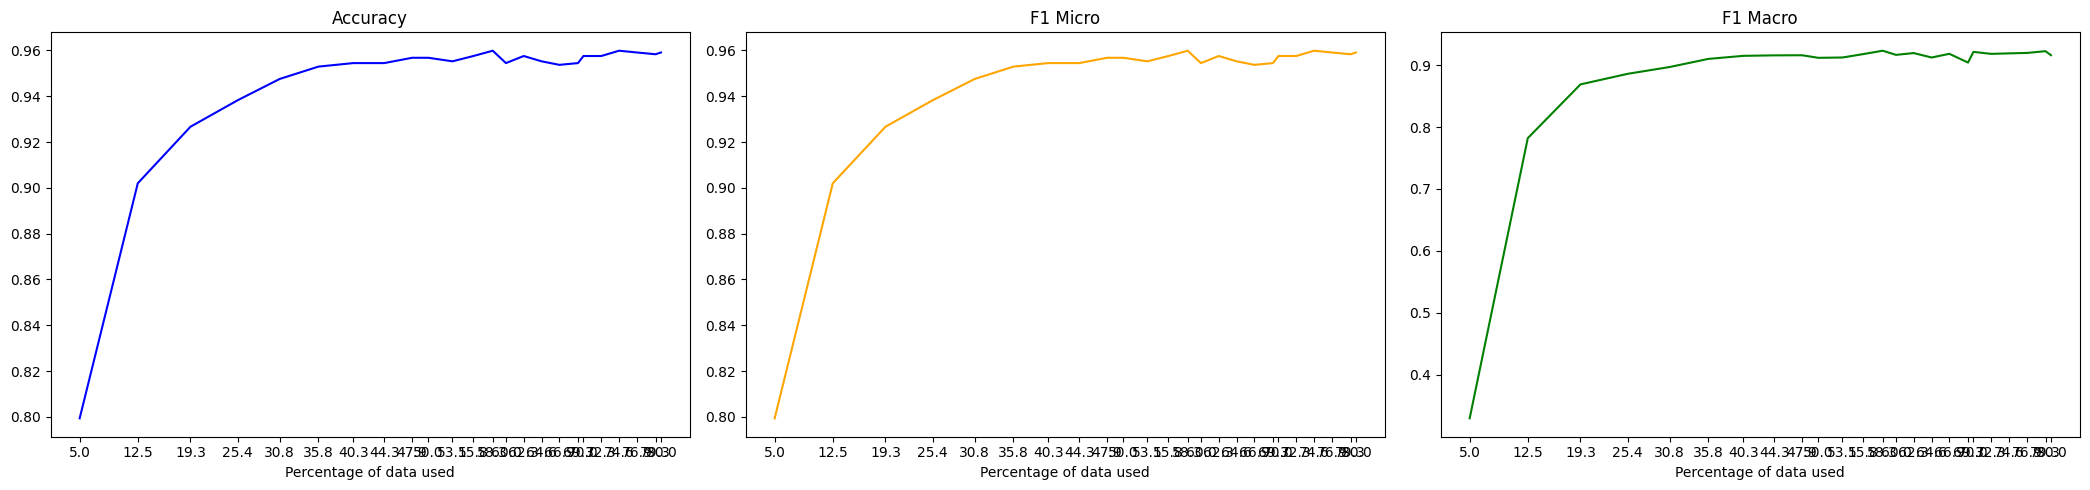

In [ ]:
active_learning(seeds[4], 4)